# Instalaciones

In [ ]:
!pip install pydicom
!pip install SimpleITK

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.0 MB 7.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 48.4 MB 27 kB/s 


# Librerías

In [ ]:
#otros
import os
import re
import cv2
import shutil
import pickle
from glob import glob
from PIL import Image

#basicos
import numpy as np
import pandas as pd

#visualización
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
%matplotlib inline

#red nuronal 
import tensorflow as tf
from keras import optimizers
from keras.regularizers import l2
from keras.models import Sequential
from keras.optimizer_v2.adam import Adam
from keras.callbacks import ModelCheckpoint
from keras.utils.vis_utils import model_to_dot
from keras.optimizer_v2.rmsprop import RMSprop
from keras.optimizer_experimental.sgd import SGD
from keras.metrics import categorical_accuracy
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from keras.models import Sequential, load_model, Model
from keras_preprocessing.image.dataframe_iterator import DataFrameIterator
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.layers import Conv2D,Conv3D,Lambda, BatchNormalization,MaxPooling2D,MaxPooling3D, Flatten,Input
from keras.layers import Dense, Dropout, GlobalAveragePooling2D,InputLayer,LeakyReLU,Concatenate,Add
#dicom
import pydicom as dicom

#mhd
import SimpleITK as sitk


# Funciones auxiliares

In [ ]:
class DicomDataGen(tf.keras.utils.Sequence):
    
    def __init__(self, df, X_col, y_col,
                 batch_size,
                 input_size=(224, 224, 19),
                 shuffle=True,
                 image_data_generator=None):
        
        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.batch_size = batch_size
        self.input_size = input_size
        self.shuffle = shuffle
        self.image_data_generator=image_data_generator

        self.n = len(self.df)
        self.n_name = df[y_col['name']].nunique()
    
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)
    
    def __get_input(self, dcm_path, target_size):
    
        dicoms=[]
        cont=0
        files_patients=sorted(glob(dcm_path+'/*'))
        dicoms=np.zeros((len(files_patients),)+target_size)
        
        for file_dcm in files_patients:
          image_array = dicom.dcmread(file_dcm).pixel_array
          image_array = cv2.resize(image_array, target_size[0:2], interpolation=cv2.INTER_NEAREST)  
          dicoms[cont]=image_array 
          cont+=1
        dicoms=np.array(dicoms,dtype='f')
        # dicoms=dicoms.reshape((dicoms.shape[1], dicoms.shape[2],dicoms.shape[0]))
        return dicoms

    def __get_output(self, label, num_classes):
        return np.array(label,dtype='int')
    
    def __get_data(self, batches):
        # Generates data containing batch_size samples

        path_batch = batches[self.X_col['path']]
              
        name_batch = batches[self.y_col['name']]

        X_batch = np.expand_dims(np.asarray([self.__get_input(x, self.input_size) for x in path_batch]), 1)

        y0_batch = np.asarray([self.__get_output(y, self.n_name) for y in name_batch])

        if self.image_data_generator is not None:
          for i, (x, y1) in enumerate(zip(X_batch, y0_batch)):
              transform_params = self.image_data_generator.get_random_transform((1,)+self.input_size)
              for k,j in enumerate(x[0]):
                X_batch[i][0][k] = np.around(self.image_data_generator.apply_transform(np.expand_dims(j,axis=-1), transform_params)[:,:,0]/255,5)

        return X_batch, y0_batch
    
    def __getitem__(self, index):
        
        batches = self.df[index * self.batch_size:(index + 1) * self.batch_size]
        X, y = self.__get_data(batches)        
        return X, y
    
    def __len__(self):
        return self.n // self.batch_size

In [ ]:
class MHDDataGen(tf.keras.utils.Sequence):
    
    def __init__(self, df, X_col, y_col,
                 batch_size,
                 input_size=(224, 224, 19),
                 shuffle=True,
                 image_data_generator=None):
        
        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.batch_size = batch_size
        self.input_size = input_size
        self.shuffle = shuffle
        self.image_data_generator=image_data_generator
        
        self.n = len(self.df)
        self.n_name = df[y_col['name']].nunique()
    
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)
    
    def __get_input(self, mhd_path, target_size):
    
        dicoms=[]
        cont=0
        itkimage = sitk.ReadImage(mhd_path)
        ct_scan = sitk.GetArrayFromImage(itkimage)
        dicoms=np.zeros((ct_scan.shape[0],)+target_size)
        for mhd_image in ct_scan:
          image_array = cv2.resize(mhd_image, target_size[0:2], interpolation=cv2.INTER_NEAREST)
          image_array=image_array
          dicoms[cont,:,:]=image_array 
          cont+=1
        dicoms=np.array(dicoms,dtype='f')
        # dicoms=dicoms.reshape((dicoms.shape[1], dicoms.shape[2],dicoms.shape[0]))
        return dicoms

    def __get_output(self, label, num_classes):
        return np.array(label,dtype='int')
    
    def __get_data(self, batches):
        # Generates data containing batch_size samples

        path_batch = batches[self.X_col['path']]
              
        name_batch = batches[self.y_col['name']]

        X_batch = np.expand_dims(np.asarray([self.__get_input(x, self.input_size) for x in path_batch]), 1)

        y0_batch = np.asarray([self.__get_output(y, self.n_name) for y in name_batch])

        if self.image_data_generator is not None:
          for i, (x, y1) in enumerate(zip(X_batch, y0_batch)):
              transform_params = self.image_data_generator.get_random_transform((1,)+self.input_size)
              for k,j in enumerate(x[0]):
                X_batch[i][0][k] = np.around(self.image_data_generator.apply_transform(np.expand_dims(j,axis=-1), transform_params)[:,:,0]/255,4)

        return X_batch, y0_batch
    
    def __getitem__(self, index):
        
        batches = self.df[index * self.batch_size:(index + 1) * self.batch_size]
        X, y = self.__get_data(batches)        
        return X, y
    
    def __len__(self):
        return self.n // self.batch_size

In [ ]:
from IPython.display import SVG
from IPython.display import clear_output

def display_model(model):
    if COLAB:
        display(SVG(model_to_dot(model, show_shapes=True,dpi=72).create(prog='dot', format='svg')))
    else:
        display(SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg')))

In [ ]:
def grafica_entrenamiento(tr_acc, val_acc, tr_loss, val_loss, best_i,
                          figsize=(10,4)):
    plt.figure(figsize=figsize)
    ax = plt.subplot(1,2,1)
    plt.plot(1+np.arange(len(tr_acc)),  100*np.array(tr_acc))
    plt.plot(1+np.arange(len(val_acc)), 100*np.array(val_acc))
    plt.plot(1+best_i, 100*val_acc[best_i], 'or')
    plt.title('tasa de acierto del modelo (%)', fontsize=18)
    plt.ylabel('tasa de acierto (%)', fontsize=18)
    plt.xlabel('época', fontsize=18)
    plt.legend(['validación', 'entrenamiento'], loc='upper left')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    plt.subplot(1,2,2)
    plt.plot(1+np.arange(len(tr_acc)), np.array(tr_loss))
    plt.plot(1+np.arange(len(val_acc)), np.array(val_loss))
    plt.plot(1+best_i, val_loss[best_i], 'or')
    plt.title('loss del modelo', fontsize=18)
    plt.ylabel('loss', fontsize=18)
    plt.xlabel('época', fontsize=18)
    plt.legend(['validación', 'entrenamiento'], loc='upper left')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.show()

In [ ]:
len([0,202,3])>2

True

In [ ]:
def to_float(x):
  ''' Objetivo: .
  ---------------------------------------------------------------------
  Input: .
  Output: .
  '''
 
  elem=x.split(sep=' ')

  if len(elem)>3:
    for item in elem:
      if item =='':
        elem.remove('')

  try:
    out=list(map(float, elem))
  except:
    out=np.nan
  return out


# Importar dataset

In [ ]:
COLAB = True

In [ ]:
if COLAB:
    from google.colab import drive
    drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df_training=pickle.load(open("/content/drive/MyDrive/Capstone/PROSTATEX_dataset/pickles/df_training.pickle","rb"))

In [ ]:
df_training.head()

,proxID,fid,dcmSerNum,pos_x,pos_y,ijk,zone,name,path_dcm,clinSig
311,ProstateX-0019,1,9,"[-4.21012, 42.1916, -40.6457]","[-4.21012, 42.1916, -40.6457]","[182, 236, 10]",PZ,t2_tse_tra0,/content/drive/MyDrive/Capstone/PROSTATEX_data...,1
314,ProstateX-0019,1,5,"[-4.21012, 42.1916, -40.6457]","[-4.21012, 42.1916, -40.6457]","[182, 236, 10]",PZ,t2_tse_tra0,/content/drive/MyDrive/Capstone/PROSTATEX_data...,1
295,ProstateX-0017,1,5,"[2.89097, 49.4408, -14.4697]","[2.89097, 49.4408, -14.4697]","[202, 233, 9]",PZ,t2_tse_tra0,/content/drive/MyDrive/Capstone/PROSTATEX_data...,0
306,ProstateX-0018,1,5,"[4.08917, 18.7769, -11.5951]","[4.08917, 18.7769, -11.5951]","[204, 174, 5]",AS,t2_tse_tra0,/content/drive/MyDrive/Capstone/PROSTATEX_data...,1
3532,ProstateX-0180,1,4,"[-41.1698, 34.6176, 45.2961]","[-41.1698, 34.6176, 45.2961]","[139, 239, 11]",PZ,t2_tse_tra0,/content/drive/MyDrive/Capstone/PROSTATEX_data...,0


# Entrenamiento de modelos

## Preparación del dataset

### MHD

Preparación para entrenar el modelo unimodalmente únicamente con el tipo de resonancia magnética: __ktrans__

In [ ]:
df_train_mhd=df_training[df_training['name']=='ktrans']
df_train_mhd.head()

,proxID,fid,dcmSerNum,pos_x,pos_y,ijk,zone,name,path_dcm,clinSig
858,ProstateX-0037,2,188,"[11.742, 38.1655, 0.0225723]","[11.742, 38.1655, 0.0225723]","[56, 74, 6]",PZ,ktrans,/content/drive/MyDrive/Capstone/PROSTATEX_data...,0
838,ProstateX-0036,1,188,"[41.2459, 52.7925, -62.1916]","[41.2459, 52.7925, -62.1916]","[77, 75, 7]",PZ,ktrans,/content/drive/MyDrive/Capstone/PROSTATEX_data...,0
2664,ProstateX-0140,1,188,"[-12.396, 24.3574, -39.5583]","[-12.396, 24.3574, -39.5583]","[47, 70, 7]",PZ,ktrans,/content/drive/MyDrive/Capstone/PROSTATEX_data...,0
2495,ProstateX-0134,2,188,"[24.5865, 41.3689, -11.8297]","[24.5865, 41.3689, -11.8297]","[73, 68, 9]",TZ,ktrans,/content/drive/MyDrive/Capstone/PROSTATEX_data...,0
940,ProstateX-0041,1,188,"[-11.24582, 60.9975, -48.0648]","[-11.24582, 60.9975, -48.0648]","[50, 79, 5]",PZ,ktrans,/content/drive/MyDrive/Capstone/PROSTATEX_data...,1


In [ ]:
patients_f=list(df_train_mhd['proxID'].value_counts().index)

In [ ]:
train_all_mhd, test_all_mhd = train_test_split(patients_f, test_size=0.3)
tr_all_mhd, val_all_mhd = train_test_split(train_all_mhd, test_size=0.2)

In [ ]:
len(tr_all_mhd),len(test_all_mhd),len(val_all_mhd)

(110, 60, 28)

In [ ]:
tr_df_all_mhd=df_train_mhd[df_train_mhd['proxID'].isin(tr_all_mhd)]
val_df_all_mhd=df_train_mhd[df_train_mhd['proxID'].isin(val_all_mhd)]
test_df_all_mhd=df_train_mhd[df_train_mhd['proxID'].isin(test_all_mhd)]

In [ ]:
tr_df_all_mhd.head()

,proxID,fid,dcmSerNum,pos_x,pos_y,ijk,zone,name,path_dcm,clinSig
3892,ProstateX-0193,4,188,"[7.42249, 43.3791, 0.138344]","[7.42249, 43.3791, 0.138344]","[62, 71, 6]",PZ,ktrans,/content/drive/MyDrive/Capstone/PROSTATEX_data...,1
70,ProstateX-0004,1,188,"[-7.69665, 3.64226, 23.1659]","[-7.69665, 3.64226, 23.1659]","[74, 56, 6]",AS,ktrans,/content/drive/MyDrive/Capstone/PROSTATEX_data...,0
957,ProstateX-0042,1,188,"[0.258727, 12.1867, 29.2257]","[0.258727, 12.1867, 29.2257]","[70, 58, 4]",TZ,ktrans,/content/drive/MyDrive/Capstone/PROSTATEX_data...,0
959,ProstateX-0043,1,188,"[8.92826, 59.9957, -1.69448]","[8.92826, 59.9957, -1.69448]","[55, 75, 13]",PZ,ktrans,/content/drive/MyDrive/Capstone/PROSTATEX_data...,0
2465,ProstateX-0133,1,188,"[22.8645, 28.3757, -26.314]","[22.8645, 28.3757, -26.314]","[66, 53, 8]",AS,ktrans,/content/drive/MyDrive/Capstone/PROSTATEX_data...,0


In [ ]:
val_df_all_mhd.head()

,proxID,fid,dcmSerNum,pos_x,pos_y,ijk,zone,name,path_dcm,clinSig
940,ProstateX-0041,1,188,"[-11.24582, 60.9975, -48.0648]","[-11.24582, 60.9975, -48.0648]","[50, 79, 5]",PZ,ktrans,/content/drive/MyDrive/Capstone/PROSTATEX_data...,1
133,ProstateX-0006,1,188,"[8.20024, 28.2665, -10.4784]","[8.20024, 28.2665, -10.4784]","[74, 70, 9]",PZ,ktrans,/content/drive/MyDrive/Capstone/PROSTATEX_data...,0
134,ProstateX-0006,2,188,"[-9.85971, 37.2739, 0.561445]","[-9.85971, 37.2739, 0.561445]","[62, 74, 13]",PZ,ktrans,/content/drive/MyDrive/Capstone/PROSTATEX_data...,0
3866,ProstateX-0192,2,188,"[4.38277, 45.7107, 13.0712]","[4.38277, 45.7107, 13.0712]","[56, 73, 10]",PZ,ktrans,/content/drive/MyDrive/Capstone/PROSTATEX_data...,0
877,ProstateX-0038,1,188,"[-35.8699, 29.366, 22.5239]","[-35.8699, 29.366, 22.5239]","[53, 63, 9]",TZ,ktrans,/content/drive/MyDrive/Capstone/PROSTATEX_data...,0


In [ ]:
test_df_all_mhd.head()

,proxID,fid,dcmSerNum,pos_x,pos_y,ijk,zone,name,path_dcm,clinSig
858,ProstateX-0037,2,188,"[11.742, 38.1655, 0.0225723]","[11.742, 38.1655, 0.0225723]","[56, 74, 6]",PZ,ktrans,/content/drive/MyDrive/Capstone/PROSTATEX_data...,0
838,ProstateX-0036,1,188,"[41.2459, 52.7925, -62.1916]","[41.2459, 52.7925, -62.1916]","[77, 75, 7]",PZ,ktrans,/content/drive/MyDrive/Capstone/PROSTATEX_data...,0
2664,ProstateX-0140,1,188,"[-12.396, 24.3574, -39.5583]","[-12.396, 24.3574, -39.5583]","[47, 70, 7]",PZ,ktrans,/content/drive/MyDrive/Capstone/PROSTATEX_data...,0
2495,ProstateX-0134,2,188,"[24.5865, 41.3689, -11.8297]","[24.5865, 41.3689, -11.8297]","[73, 68, 9]",TZ,ktrans,/content/drive/MyDrive/Capstone/PROSTATEX_data...,0
2440,ProstateX-0131,1,188,"[51.1849, 25.9864, 12.9275]","[51.1849, 25.9864, 12.9275]","[70, 60, 9]",AS,ktrans,/content/drive/MyDrive/Capstone/PROSTATEX_data...,1


#### Export datos de entrenamiento

In [ ]:
path_pickle='/content/drive/MyDrive/Capstone/PROSTATEX_dataset/pickles/'
pickle_out=open(path_pickle+"tr_df_all_mhd.pickle","wb")
pickle.dump(tr_df_all_mhd,pickle_out)
pickle_out.close()

path_pickle='/content/drive/MyDrive/Capstone/PROSTATEX_dataset/pickles/'
pickle_out=open(path_pickle+"val_df_all_mhd.pickle","wb")
pickle.dump(val_df_all_mhd,pickle_out)
pickle_out.close()

path_pickle='/content/drive/MyDrive/Capstone/PROSTATEX_dataset/pickles/'
pickle_out=open(path_pickle+"test_df_all_mhd.pickle","wb")
pickle.dump(test_df_all_mhd,pickle_out)
pickle_out.close()

### DICOM

In [ ]:
df_train_dcm=df_training[df_training['name']!='ktrans']
df_train_dcm.head()

,proxID,fid,dcmSerNum,pos_x,pos_y,ijk,zone,name,path_dcm,clinSig
311,ProstateX-0019,1,9,"[-4.21012, 42.1916, -40.6457]","[-4.21012, 42.1916, -40.6457]","[182, 236, 10]",PZ,t2_tse_tra0,/content/drive/MyDrive/Capstone/PROSTATEX_data...,1
314,ProstateX-0019,1,5,"[-4.21012, 42.1916, -40.6457]","[-4.21012, 42.1916, -40.6457]","[182, 236, 10]",PZ,t2_tse_tra0,/content/drive/MyDrive/Capstone/PROSTATEX_data...,1
295,ProstateX-0017,1,5,"[2.89097, 49.4408, -14.4697]","[2.89097, 49.4408, -14.4697]","[202, 233, 9]",PZ,t2_tse_tra0,/content/drive/MyDrive/Capstone/PROSTATEX_data...,0
306,ProstateX-0018,1,5,"[4.08917, 18.7769, -11.5951]","[4.08917, 18.7769, -11.5951]","[204, 174, 5]",AS,t2_tse_tra0,/content/drive/MyDrive/Capstone/PROSTATEX_data...,1
3532,ProstateX-0180,1,4,"[-41.1698, 34.6176, 45.2961]","[-41.1698, 34.6176, 45.2961]","[139, 239, 11]",PZ,t2_tse_tra0,/content/drive/MyDrive/Capstone/PROSTATEX_data...,0


In [ ]:
patients_f=list(df_train_dcm['proxID'].value_counts().index)

In [ ]:
train_all_dcm, test_all_dcm = train_test_split(patients_f, test_size=0.3)
tr_all_dcm, val_all_dcm = train_test_split(train_all_dcm, test_size=0.2)

In [ ]:
len(tr_all_mhd),len(test_all_mhd),len(val_all_mhd)

(110, 60, 28)

In [ ]:
tr_df_all_dcm=df_train_dcm[df_train_dcm['proxID'].isin(tr_all_dcm)]
val_df_all_dcm=df_train_dcm[df_train_dcm['proxID'].isin(val_all_dcm)]
test_df_all_dcm=df_train_dcm[df_train_dcm['proxID'].isin(test_all_dcm)]

In [ ]:
tr_df_all_dcm.head()

,proxID,fid,dcmSerNum,pos_x,pos_y,ijk,zone,name,path_dcm,clinSig
295,ProstateX-0017,1,5,"[2.89097, 49.4408, -14.4697]","[2.89097, 49.4408, -14.4697]","[202, 233, 9]",PZ,t2_tse_tra0,/content/drive/MyDrive/Capstone/PROSTATEX_data...,0
306,ProstateX-0018,1,5,"[4.08917, 18.7769, -11.5951]","[4.08917, 18.7769, -11.5951]","[204, 174, 5]",AS,t2_tse_tra0,/content/drive/MyDrive/Capstone/PROSTATEX_data...,1
3532,ProstateX-0180,1,4,"[-41.1698, 34.6176, 45.2961]","[-41.1698, 34.6176, 45.2961]","[139, 239, 11]",PZ,t2_tse_tra0,/content/drive/MyDrive/Capstone/PROSTATEX_data...,0
1029,ProstateX-0048,1,4,"[18.4772, 48.0755, -83.6069]","[18.4772, 48.0755, -83.6069]","[229, 208, 7]",PZ,t2_tse_tra0,/content/drive/MyDrive/Capstone/PROSTATEX_data...,0
3465,ProstateX-0177,1,4,"[-24.6506, 13.6168, -17.1067]","[-24.6506, 13.6168, -17.1067]","[151, 177, 8]",PZ,t2_tse_tra0,/content/drive/MyDrive/Capstone/PROSTATEX_data...,0


In [ ]:
val_df_all_dcm.head()

,proxID,fid,dcmSerNum,pos_x,pos_y,ijk,zone,name,path_dcm,clinSig
414,ProstateX-0025,4,4,"[21.9659, 22.9866, -63.5253]","[21.9659, 22.9866, -63.5253]","[240, 181, 4]",PZ,t2_tse_tra0,/content/drive/MyDrive/Capstone/PROSTATEX_data...,0
418,ProstateX-0025,1,4,"[23.6983, 51.83, -55.7923]","[34.8707, 51.5015, -3.06943]","[243, 231, 9]",PZ,t2_tse_tra0,/content/drive/MyDrive/Capstone/PROSTATEX_data...,0
419,ProstateX-0025,1,4,"[23.6983, 51.83, -55.7923]","[23.6983, 51.83, -55.7923]","[243, 231, 9]",PZ,t2_tse_tra0,/content/drive/MyDrive/Capstone/PROSTATEX_data...,0
422,ProstateX-0025,1,4,"[34.8707, 51.5015, -3.06943]","[34.8707, 51.5015, -3.06943]","[266, 200, 26]",PZ,t2_tse_tra0,/content/drive/MyDrive/Capstone/PROSTATEX_data...,0
423,ProstateX-0025,1,4,"[34.8707, 51.5015, -3.06943]","[23.6983, 51.83, -55.7923]","[266, 200, 26]",PZ,t2_tse_tra0,/content/drive/MyDrive/Capstone/PROSTATEX_data...,0


In [ ]:
test_df_all_dcm.head()

,proxID,fid,dcmSerNum,pos_x,pos_y,ijk,zone,name,path_dcm,clinSig
311,ProstateX-0019,1,9,"[-4.21012, 42.1916, -40.6457]","[-4.21012, 42.1916, -40.6457]","[182, 236, 10]",PZ,t2_tse_tra0,/content/drive/MyDrive/Capstone/PROSTATEX_data...,1
314,ProstateX-0019,1,5,"[-4.21012, 42.1916, -40.6457]","[-4.21012, 42.1916, -40.6457]","[182, 236, 10]",PZ,t2_tse_tra0,/content/drive/MyDrive/Capstone/PROSTATEX_data...,1
2343,ProstateX-0128,2,5,"[-29.2246, 33.9741, 10.7415]","[-29.2246, 33.9741, 10.7415]","[167, 199, 9]",TZ,t2_tse_tra0,/content/drive/MyDrive/Capstone/PROSTATEX_data...,0
2342,ProstateX-0128,1,5,"[-34.0393, 43.4712, 4.89498]","[-34.0393, 43.4712, 4.89498]","[158, 218, 8]",PZ,t2_tse_tra0,/content/drive/MyDrive/Capstone/PROSTATEX_data...,1
2341,ProstateX-0128,3,5,"[-10.8589, 36.4117, -4.54883]","[-10.8589, 36.4117, -4.54883]","[204, 203, 4]",PZ,t2_tse_tra0,/content/drive/MyDrive/Capstone/PROSTATEX_data...,0


In [ ]:
test_df_all_dcm['name'].value_counts()

tfl_3d_dynamisch_fast0             140
t2_tse_sag0                        109
tfl_3d_PD_ref_tra_1_5x1_5_t30      103
t2_tse_tra0                         65
ep2d_diff_tra_DYNDIST0              59
ep2d_diff_tra_DYNDISTCALC_BVAL0     59
ep2d_diff_tra_DYNDIST_ADC0          59
ep2d_diff_tra_DYNDIST1              59
ep2d_diff_tra_DYNDIST2              59
t2_tse_cor0                         51
Name: name, dtype: int64

#### Export datos de entrenamiento

In [ ]:
path_pickle='/content/drive/MyDrive/Capstone/PROSTATEX_dataset/pickles/'
pickle_out=open(path_pickle+"tr_df_all_dcm.pickle","wb")
pickle.dump(tr_df_all_dcm,pickle_out)
pickle_out.close()

path_pickle='/content/drive/MyDrive/Capstone/PROSTATEX_dataset/pickles/'
pickle_out=open(path_pickle+"val_df_all_dcm.pickle","wb")
pickle.dump(val_df_all_dcm,pickle_out)
pickle_out.close()

path_pickle='/content/drive/MyDrive/Capstone/PROSTATEX_dataset/pickles/'
pickle_out=open(path_pickle+"test_df_all_dcm.pickle","wb")
pickle.dump(test_df_all_dcm,pickle_out)
pickle_out.close()

## Data augmentation

Constantes de data augmentation

In [ ]:
def preprocess_input(x):
    return x*255.

train_augmentation_parameters = dict(
    # rescale=1.0/255.0,
    preprocessing_function=preprocess_input,
    rotation_range=10,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    brightness_range = [0.8, 1.2],
    validation_split = 0.2
)

valid_augmentation_parameters = dict(
    # rescale=1.0/255.0,
    validation_split = 0.2
)

test_augmentation_parameters = dict(
    # rescale=1.0/255.0
)

# training parameters
BATCH_SIZE = 4
CLASS_MODE = 'binary'
COLOR_MODE = 'grayscale'
TARGET_SIZE = (300, 300)
EPOCHS = 50
SEED = 1992

train_consts = {
    'seed': SEED,
    'batch_size': BATCH_SIZE,
    'class_mode': CLASS_MODE,
    'color_mode': COLOR_MODE,
    'target_size': TARGET_SIZE,  
    'subset': 'training'
}

valid_consts = {
    'seed': SEED,
    'batch_size': BATCH_SIZE,
    'class_mode': CLASS_MODE,
    'color_mode': COLOR_MODE,
    'target_size': TARGET_SIZE, 
    'subset': 'validation'
}

test_consts = {
    'batch_size': 1,  # should be 1 in testing
    'class_mode': CLASS_MODE,
    'color_mode': COLOR_MODE,
    'target_size': TARGET_SIZE,  # resize input images
    'shuffle': False
}

# Using the training phase generators 
train_augmenter = ImageDataGenerator(**train_augmentation_parameters)
valid_augmenter = ImageDataGenerator(**valid_augmentation_parameters)


## Modelo con CNN's utilizando resonancia magnética __ktrans__

In [ ]:
traingen = MHDDataGen(tr_df_all_mhd,
                      X_col={'path':'path_dcm'},
                      y_col={'name': 'clinSig'},
                      image_data_generator=train_augmenter,
                      batch_size=BATCH_SIZE, input_size=TARGET_SIZE)

valgen = MHDDataGen(val_df_all_mhd,
                    X_col={'path':'path_dcm'},
                    y_col={'name': 'clinSig'},
                    image_data_generator=valid_augmenter,
                    batch_size=BATCH_SIZE, input_size=TARGET_SIZE)

testgen=MHDDataGen(test_df_all_mhd,
                   X_col={'path':'path_dcm'},
                   y_col={'name': 'clinSig'},
                   batch_size=BATCH_SIZE, input_size=TARGET_SIZE)


In [ ]:
X, y= traingen[0]
X.shape

(2, 1, 16, 300, 300)

In [ ]:
X[0,:,0][0].shape

(300, 300)

In [ ]:
X[0,:,0][0].max(),X[0,:,0][0].min()

(0.9922, 0.0)

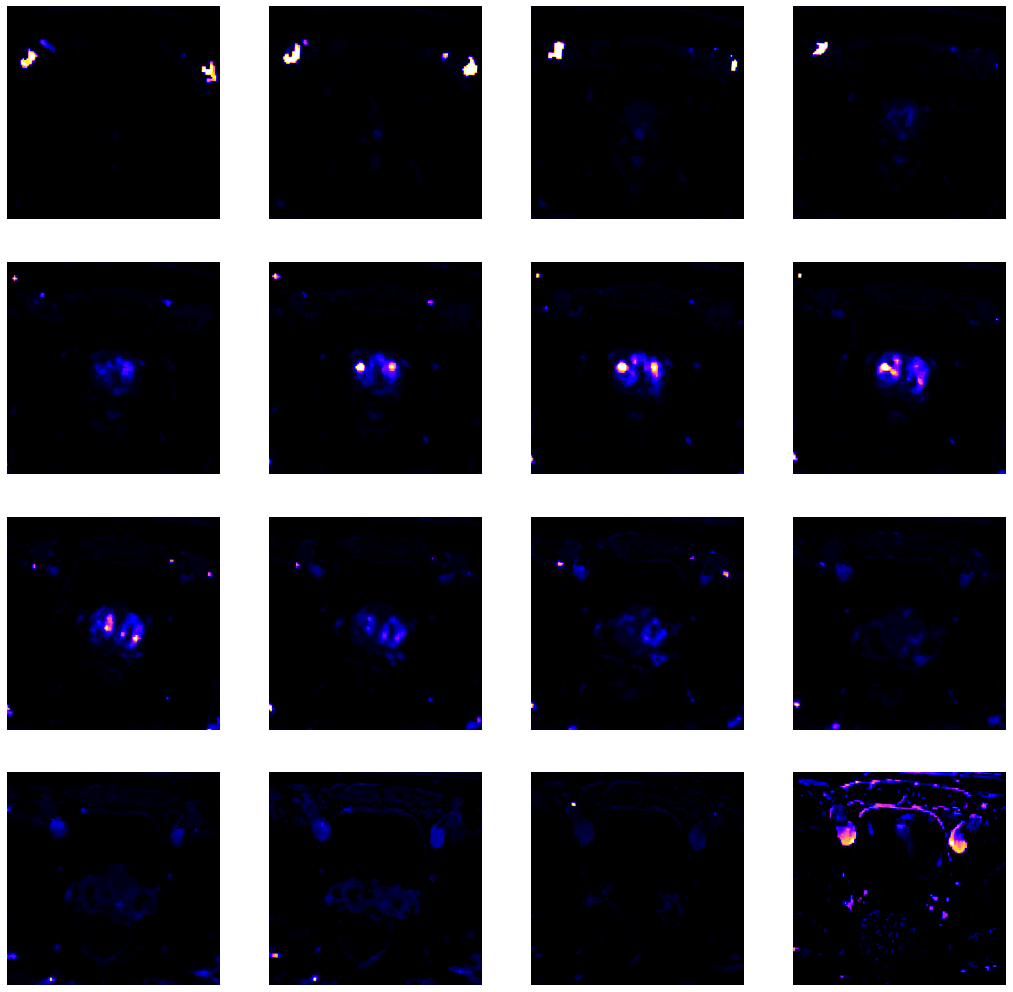

In [ ]:
num_plots=int(np.sqrt(X.shape[2]))
fig, axs = plt.subplots(num_plots,num_plots,figsize=(18, 18))

for block in X:
  im=np.squeeze(block)
  for slice1,ax in zip(im, axs.ravel()):
    ax.imshow(slice1,cmap='gnuplot2')
    ax.axis("off")

In [ ]:
y.shape

(2,)

In [ ]:
y

array([0, 0])

In [ ]:
X.shape[1:]

(1, 16, 300, 300)

In [ ]:
# define model architecture like how you normally do

input_dims=X.shape[1:]
inputs = Input(shape=input_dims)
x1=Conv3D(filters=16, padding='same',kernel_initializer='he_uniform',
          kernel_size=(1,7,7), activation='relu')(inputs)
x1_1=LeakyReLU(0.3)(x1)

x2=Conv3D(filters=32,padding='same',kernel_initializer='he_uniform',
          kernel_size=(1,3,3), activation='relu')(inputs)
x2_1=LeakyReLU(0.3)(x2)

# x3=Conv3D(filters=64, padding='same', kernel_initializer='he_uniform',
#           kernel_size=(1,3,3), activation='relu')(inputs)
# x3_1=LeakyReLU(0.3)(x3)

# x4=Concatenate()([x1_1,x2_1,x3_1])
x4=Concatenate()([x1_1,x2_1])

x5=MaxPooling3D(pool_size=(2,2,2), padding='same')(x4)
x6=Conv3D(filters=64, padding='same', kernel_size=(2,3,3), activation='relu')(x5)
x6_1=LeakyReLU(0.1)(x6)

x7=Conv3D(filters=64, padding='same', kernel_size=(2,3,3), activation='relu')(x6_1)
x7_1=LeakyReLU(0.1)(x7)

x8=Conv3D(filters=32, padding='same', kernel_size=(2,3,3), activation='relu')(x7_1)
x8_1=LeakyReLU(0.1)(x8)

x9=Flatten()(x8_1)
x10=Dropout(0.3)(x9)
#x=Dense(64, activation='relu',
#        kernel_regularizer=l2(0.01)
#        )(x10)
x=Dropout(0.3)(x10)
x=Dense(16, activation='relu',
        kernel_regularizer=l2(0.01)
        )(x)     
x=Dropout(0.3)(x)
x=Dense(10, activation='relu',
        kernel_regularizer=l2(0.01)
        )(x)  


out1 = Dense(1, activation="sigmoid",name="out1")(x)

model = Model(inputs=inputs, outputs=out1)


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1, 16, 300,  0           []                               
                                 300)]                                                            
                                                                                                  
 conv3d (Conv3D)                (None, 1, 16, 300,   235216      ['input_1[0][0]']                
                                16)                                                               
                                                                                                  
 conv3d_1 (Conv3D)              (None, 1, 16, 300,   86432       ['input_1[0][0]']                
                                32)                                                           

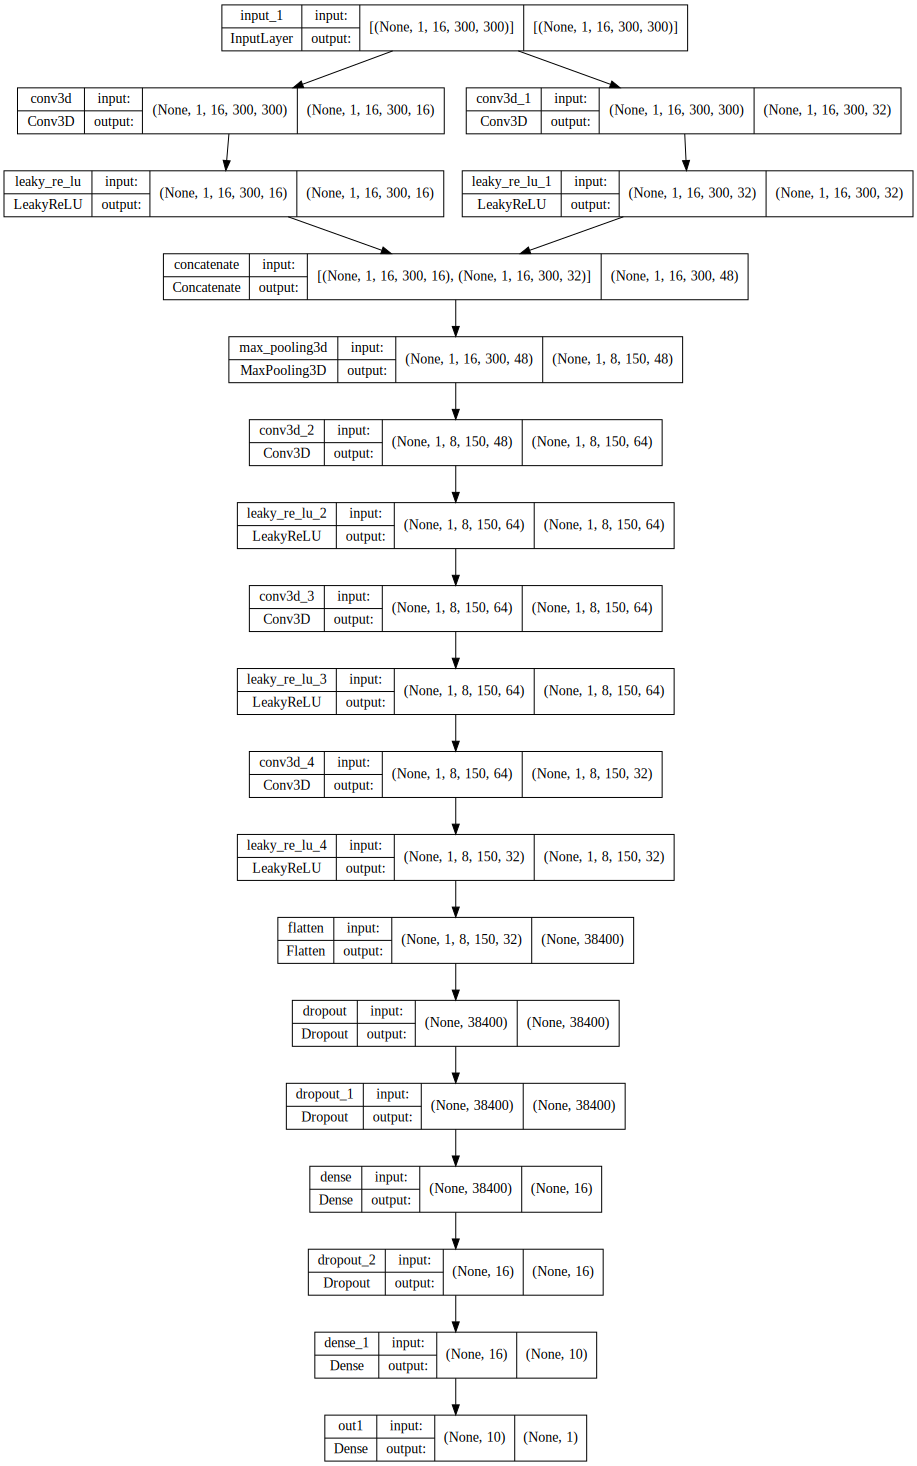

In [ ]:
if COLAB:
    display(SVG(model_to_dot(model, show_shapes=True,dpi=72).create(prog='dot', format='svg')))
else:
    display(SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg')))

In [ ]:
number_train_samples=tr_df_all_mhd.shape[0]
num_train_steps=(number_train_samples // BATCH_SIZE)*EPOCHS
lr_scheduler = tf.keras.optimizers.schedules.PolynomialDecay(initial_learning_rate=0.001,
                               end_learning_rate=1e-8,
                               decay_steps=num_train_steps)

In [ ]:
acum_tr_acc = []
acum_val_acc = []
best_val_acc = -1000
acum_tr_loss  = []
acum_val_loss = []

In [ ]:
model.compile(loss='binary_crossentropy',
             optimizer=Adam(learning_rate=lr_scheduler),
              # optimizer=SGD(lr = 0.01, decay = 1e-6, momentum = 0.9, nesterov = True),
              # optimizer=optimizers.rmsprop_v2.RMSprop(learning_rate=0.001),
              metrics=['binary_accuracy'])

In [ ]:
modelpath="/content/drive/MyDrive/Capstone/Modelos/model_current_best_ktrans.h5"

checkpoint = ModelCheckpoint(modelpath, monitor='val_binary_accuracy', verbose=1,
                             save_best_only=True,
                             mode='max') # graba sólo los que mejoran en validación
callbacks_list = [checkpoint]

In [ ]:
number_train_samples = traingen.n
number_val_samples   = valgen.n
number_test_samples  = testgen.n

number_train_samples, number_val_samples, number_test_samples

(189, 45, 99)

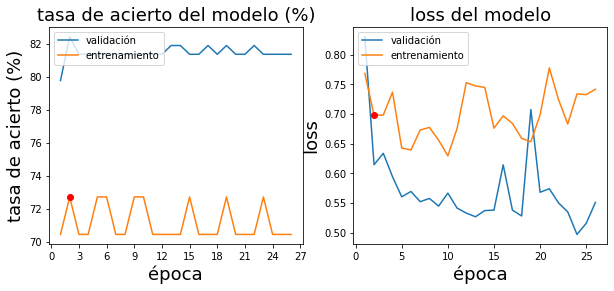

23/94 [======>.......................] - ETA: 23s - loss: 0.4949 - binary_accuracy: 0.8043

KeyboardInterrupt: ignored

In [ ]:
for e in range(EPOCHS):
    history = model.fit(traingen,  
                        steps_per_epoch=number_train_samples // BATCH_SIZE,
                        epochs=1,
                        callbacks=callbacks_list,
                        verbose=1,
                        shuffle = True,
                        validation_data=valgen,
                        validation_steps=number_val_samples // BATCH_SIZE
                       )
    
    if history.history['val_binary_accuracy'][-1] > best_val_acc:
        print("Validation accuracy improved from",
            best_val_acc, 'to', history.history['val_binary_accuracy'])
        print("saving weights")
        best_val_acc = history.history['val_binary_accuracy'][-1]
    
    acum_tr_acc.append(history.history['binary_accuracy'][0])
    acum_val_acc.append(history.history['val_binary_accuracy'][0])
    acum_tr_loss.append(history.history['loss'][0])
    acum_val_loss.append(history.history['val_loss'][0])
    
    if len(acum_tr_acc) > 1:
        clear_output()
        best_i = np.argmax(acum_val_acc)
        grafica_entrenamiento(acum_tr_acc, acum_val_acc, acum_tr_loss, acum_val_loss, best_i)

In [ ]:
model.history.history

{}

In [ ]:
Ç# Using the testing generator to evaluate the model after training

test_loss, test_accuracy = model.evaluate(testgen, steps=number_test_samples// BATCH_SIZE)

## Modelo con CNN's utilizando resonancia magnética __adc__

In [ ]:
mri='ep2d_diff_tra_DYNDIST_ADC0'                  

In [ ]:
tr_df_all_adc=tr_df_all_dcm[tr_df_all_dcm['name']==mri]
val_df_all_adc=val_df_all_dcm[val_df_all_dcm['name']==mri]
test_df_all_adc=test_df_all_dcm[test_df_all_dcm['name']==mri]

In [ ]:
traingen = DicomDataGen(tr_df_all_adc,
                        X_col={'path':'path_dcm'},
                        y_col={'name': 'clinSig'},
                        image_data_generator=train_augmenter,
                        batch_size=BATCH_SIZE, input_size=TARGET_SIZE)

valgen = DicomDataGen(val_df_all_adc,
                      X_col={'path':'path_dcm'},
                      y_col={'name': 'clinSig'},
                      image_data_generator=valid_augmenter,
                      batch_size=BATCH_SIZE, input_size=TARGET_SIZE)

testgen=DicomDataGen(test_df_all_adc,
                     X_col={'path':'path_dcm'},
                     y_col={'name': 'clinSig'},
                     batch_size=BATCH_SIZE, input_size=TARGET_SIZE)


In [ ]:
X, y= traingen[0]
X.shape

(4, 1, 19, 300, 300)

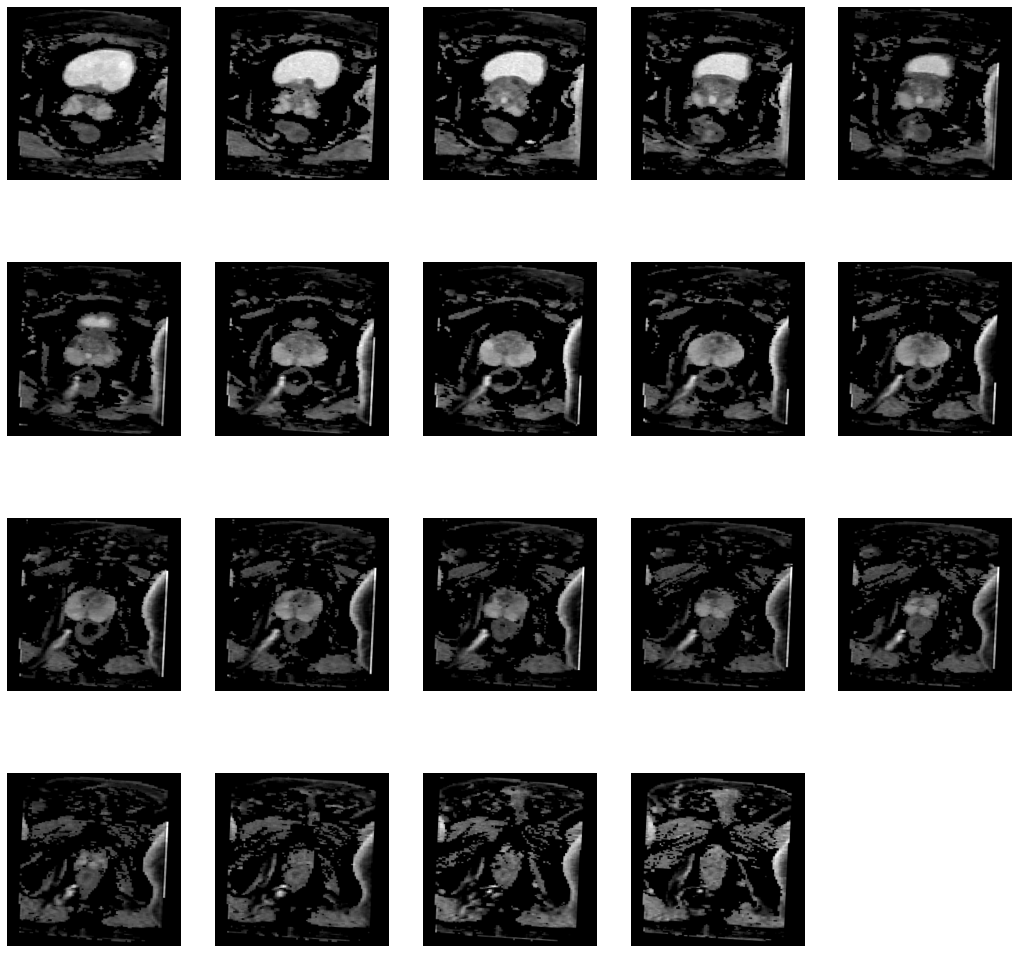

In [ ]:
num_plots=int(np.sqrt(X.shape[2]))
if num_plots**2<X.shape[2]:
  fig, axs=plt.subplots(num_plots,num_plots+1,figsize=(18, 18))
else:
  fig, axs = plt.subplots(num_plots,num_plots,figsize=(18, 18))

for block in X:
  im=np.squeeze(block)
  for slice1,ax in zip(im, axs.ravel()):
    ax.imshow(slice1,cmap='gray')
    ax.axis("off")
plt.axis("off");

In [ ]:
y.shape

(4,)

In [ ]:
y

array([0, 1, 0, 0])

In [ ]:
X.shape[1:]

(1, 19, 300, 300)

In [ ]:
X[0][0][0].max(),X[0][0][0].min()

(1.0, 0.0)

In [ ]:
# define model architecture like how you normally do

input_dims=X.shape[1:]
inputs = Input(shape=input_dims)
x1=Conv3D(filters=16, padding='same',kernel_initializer='he_uniform',
          kernel_size=(1,7,7), activation='relu')(inputs)
x1_1=LeakyReLU(0.1)(x1)

x2=Conv3D(filters=32,padding='same',kernel_initializer='he_uniform',
          kernel_size=(1,3,3), activation='relu')(inputs)
x2_1=LeakyReLU(0.1)(x2)

# x3=Conv3D(filters=32, padding='same', kernel_initializer='he_uniform',
#           kernel_size=(1,3,3), activation='relu')(inputs)
# x3_1=LeakyReLU(0.3)(x3)

# x4=Concatenate()([x1_1,x2_1,x3_1])
x4=Concatenate()([x1_1,x2_1])

x5=MaxPooling3D(pool_size=(2,2,2), padding='same')(x4)
x6=Conv3D(filters=64, padding='same', kernel_size=(2,3,3), activation='relu')(x5)
x6_1=LeakyReLU(0.2)(x6)

x7=Conv3D(filters=64, padding='same', kernel_size=(2,3,3), activation='relu')(x6_1)
x7_1=LeakyReLU(0.2)(x7)

x8=Conv3D(filters=32, padding='same', kernel_size=(2,3,3), activation='relu')(x7_1)
x8_1=LeakyReLU(0.2)(x8)

x9=Flatten()(x8_1)
x10=Dropout(0.5)(x9)
x=Dense(64, activation='relu',
        kernel_regularizer=l2(0.01)
        )(x10)
x=Dropout(0.3)(x)
x=Dense(32, activation='relu',
        kernel_regularizer=l2(0.01)
        )(x)     
x=Dropout(0.3)(x)
x=Dense(10, activation='relu',
        kernel_regularizer=l2(0.01)
        )(x)  


out1 = Dense(1, activation="sigmoid",name="out1")(x)

model = Model(inputs=inputs, outputs=out1)




In [ ]:
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 1, 19, 300,  0           []                               
                                 300)]                                                            
                                                                                                  
 conv3d_30 (Conv3D)             (None, 1, 19, 300,   235216      ['input_7[0][0]']                
                                16)                                                               
                                                                                                  
 conv3d_31 (Conv3D)             (None, 1, 19, 300,   86432       ['input_7[0][0]']                
                                32)                                                         

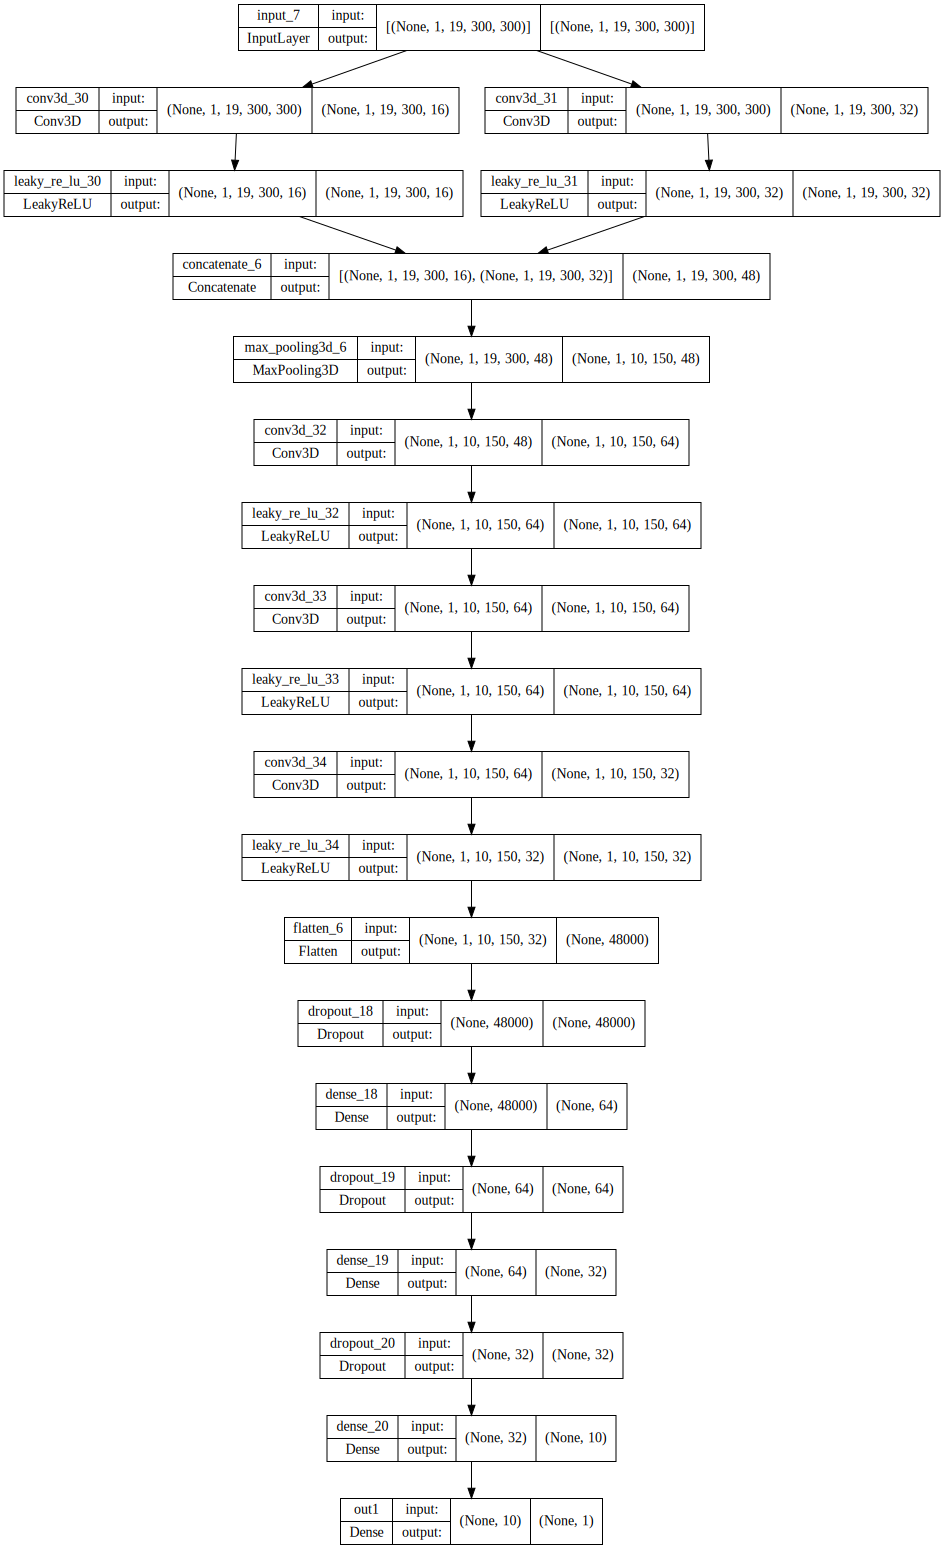

In [ ]:
if COLAB:
    display(SVG(model_to_dot(model, show_shapes=True,dpi=72).create(prog='dot', format='svg')))
else:
    display(SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg')))

In [ ]:
number_train_samples=tr_df_all_dcm.shape[0]
num_train_steps=(number_train_samples // BATCH_SIZE)*EPOCHS
lr_scheduler = tf.keras.optimizers.schedules.PolynomialDecay(initial_learning_rate=0.001,
                               end_learning_rate=1e-8,
                               decay_steps=num_train_steps)

In [ ]:
acum_tr_acc = []
acum_val_acc = []
best_val_acc = -1000
acum_tr_loss  = []
acum_val_loss = []

In [ ]:
model.compile(loss='binary_crossentropy',
             optimizer=Adam(learning_rate=lr_scheduler),
              # optimizer=SGD(lr = 0.01, decay = 1e-6, momentum = 0.9, nesterov = True),
              # optimizer=optimizers.rmsprop_v2.RMSprop(learning_rate=0.001),
              metrics=['binary_accuracy'])

In [ ]:
modelpath="/content/drive/MyDrive/model_current_best_adc.h5"

checkpoint = ModelCheckpoint(modelpath, monitor='val_binary_accuracy', verbose=1,
                             save_best_only=True,
                             mode='max') # graba sólo los que mejoran en validación
callbacks_list = [checkpoint]

In [ ]:
number_train_samples = traingen.n
number_val_samples   = valgen.n
number_test_samples  = testgen.n

number_train_samples, number_val_samples, number_test_samples

(125, 50, 59)

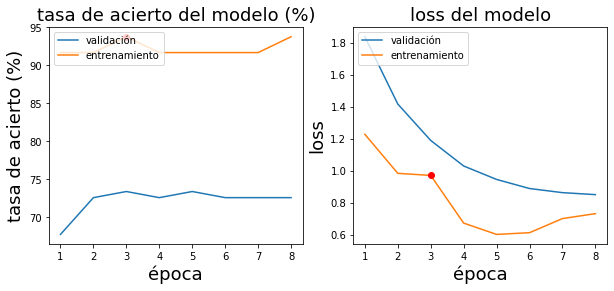

 7/31 [=====>........................] - ETA: 26s - loss: 0.8179 - binary_accuracy: 0.6786

KeyboardInterrupt: ignored

In [ ]:
for e in range(EPOCHS):
    history = model.fit(traingen,  
                        steps_per_epoch=number_train_samples // BATCH_SIZE,
                        epochs=1,
                        callbacks=callbacks_list,
                        verbose=1,
                        shuffle = True,
                        validation_data=valgen,
                        validation_steps=number_val_samples // BATCH_SIZE
                       )
    
    if history.history['val_binary_accuracy'][-1] > best_val_acc:
        print("Validation accuracy improved from",
            best_val_acc, 'to', history.history['val_binary_accuracy'])
        print("saving weights")
        best_val_acc = history.history['val_binary_accuracy'][-1]
    
    acum_tr_acc.append(history.history['binary_accuracy'][0])
    acum_val_acc.append(history.history['val_binary_accuracy'][0])
    acum_tr_loss.append(history.history['loss'][0])
    acum_val_loss.append(history.history['val_loss'][0])
    
    if len(acum_tr_acc) > 1:
        clear_output()
        best_i = np.argmax(acum_val_acc)
        grafica_entrenamiento(acum_tr_acc, acum_val_acc, acum_tr_loss, acum_val_loss, best_i)

In [ ]:
history.history

{'binary_accuracy': [0.7847222089767456],
 'loss': [0.6401336789131165],
 'val_binary_accuracy': [0.625],
 'val_loss': [1.7349709272384644]}

In [ ]:
# Using the testing generator to evaluate the model after training

test_loss, test_accuracy = model.evaluate(testgen, steps=number_test_samples// BATCH_SIZE)

## Modelo con CNN's utilizando resonancia magnética __tfl_tra__

In [ ]:
tr_df_all_dcm['name'].value_counts()

tfl_3d_dynamisch_fast0             245
t2_tse_sag0                        210
tfl_3d_PD_ref_tra_1_5x1_5_t30      204
ep2d_diff_tra_DYNDIST0             140
ep2d_diff_tra_DYNDISTCALC_BVAL0    140
ep2d_diff_tra_DYNDIST1             140
ep2d_diff_tra_DYNDIST2             140
ep2d_diff_tra_DYNDIST_ADC0         137
t2_tse_tra0                        124
t2_tse_cor0                        100
Name: name, dtype: int64

In [ ]:
mri='tfl_3d_PD_ref_tra_1_5x1_5_t30'                        

In [ ]:
tr_df_all_adc=tr_df_all_dcm[tr_df_all_dcm['name']==mri]
val_df_all_adc=val_df_all_dcm[val_df_all_dcm['name']==mri]
test_df_all_adc=test_df_all_dcm[test_df_all_dcm['name']==mri]

In [ ]:
tr_df_all_adc

,proxID,fid,dcmSerNum,pos_x,pos_y,ijk,zone,name,path_dcm,clinSig
1745,ProstateX-0095,1,10,"[-29.8824, 33.0609, 17.1315]","[-29.8824, 33.0609, 17.1315]","[57, 72, 9]",PZ,tfl_3d_PD_ref_tra_1_5x1_5_t30,/content/drive/MyDrive/Capstone/PROSTATEX_data...,1
2709,ProstateX-0142,3,9,"[21.5867, 12.2297, 48.2092]","[21.5867, 12.2297, 48.2092]","[59, 50, 10]",AS,tfl_3d_PD_ref_tra_1_5x1_5_t30,/content/drive/MyDrive/Capstone/PROSTATEX_data...,0
2143,ProstateX-0117,3,9,"[25.9078, 38.5042, -46.8451]","[25.9078, 38.5042, -46.8451]","[72, 70, 8]",PZ,tfl_3d_PD_ref_tra_1_5x1_5_t30,/content/drive/MyDrive/Capstone/PROSTATEX_data...,0
1144,ProstateX-0057,1,9,"[-5.013, 52.868, 7.27444]","[-5.013, 52.868, 7.27444]","[53, 75, 12]",PZ,tfl_3d_PD_ref_tra_1_5x1_5_t30,/content/drive/MyDrive/Capstone/PROSTATEX_data...,0
2803,ProstateX-0147,1,10,"[-33.4804, 41.3495, -25.21]","[-33.4804, 41.3495, -25.21]","[52, 78, 6]",PZ,tfl_3d_PD_ref_tra_1_5x1_5_t30,/content/drive/MyDrive/Capstone/PROSTATEX_data...,0
...,...,...,...,...,...,...,...,...,...,...
1050,ProstateX-0050,1,9,"[11.8784, 16.0017, -26.537]","[11.8784, 16.0017, -26.537]","[73, 64, 5]",PZ,tfl_3d_PD_ref_tra_1_5x1_5_t30,/content/drive/MyDrive/Capstone/PROSTATEX_data...,0
251,ProstateX-0013,1,9,"[-42.7915, 30.7382, 5.60159]","[-42.7915, 30.7382, 5.60159]","[42, 68, 9]",PZ,tfl_3d_PD_ref_tra_1_5x1_5_t30,/content/drive/MyDrive/Capstone/PROSTATEX_data...,0
2653,ProstateX-0140,1,9,"[-12.396, 24.3574, -39.5583]","[-12.396, 24.3574, -39.5583]","[47, 70, 7]",PZ,tfl_3d_PD_ref_tra_1_5x1_5_t30,/content/drive/MyDrive/Capstone/PROSTATEX_data...,0
3110,ProstateX-0160,1,10,"[-8.4535, 45.119, -25.2647]","[-8.4535, 45.119, -25.2647]","[56, 76, 11]",PZ,tfl_3d_PD_ref_tra_1_5x1_5_t30,/content/drive/MyDrive/Capstone/PROSTATEX_data...,0


In [ ]:
traingen = DicomDataGen(tr_df_all_adc,
                        X_col={'path':'path_dcm'},
                        y_col={'name': 'clinSig'},
                        image_data_generator=train_augmenter,
                        batch_size=BATCH_SIZE, input_size=TARGET_SIZE)

valgen = DicomDataGen(val_df_all_adc,
                      X_col={'path':'path_dcm'},
                      y_col={'name': 'clinSig'},
                      image_data_generator=valid_augmenter,
                      batch_size=BATCH_SIZE, input_size=TARGET_SIZE)

testgen=DicomDataGen(test_df_all_adc,
                     X_col={'path':'path_dcm'},
                     y_col={'name': 'clinSig'},
                     batch_size=BATCH_SIZE, input_size=TARGET_SIZE)


In [ ]:
X, y= traingen[0]
X.shape

(16, 1, 16, 300, 300)

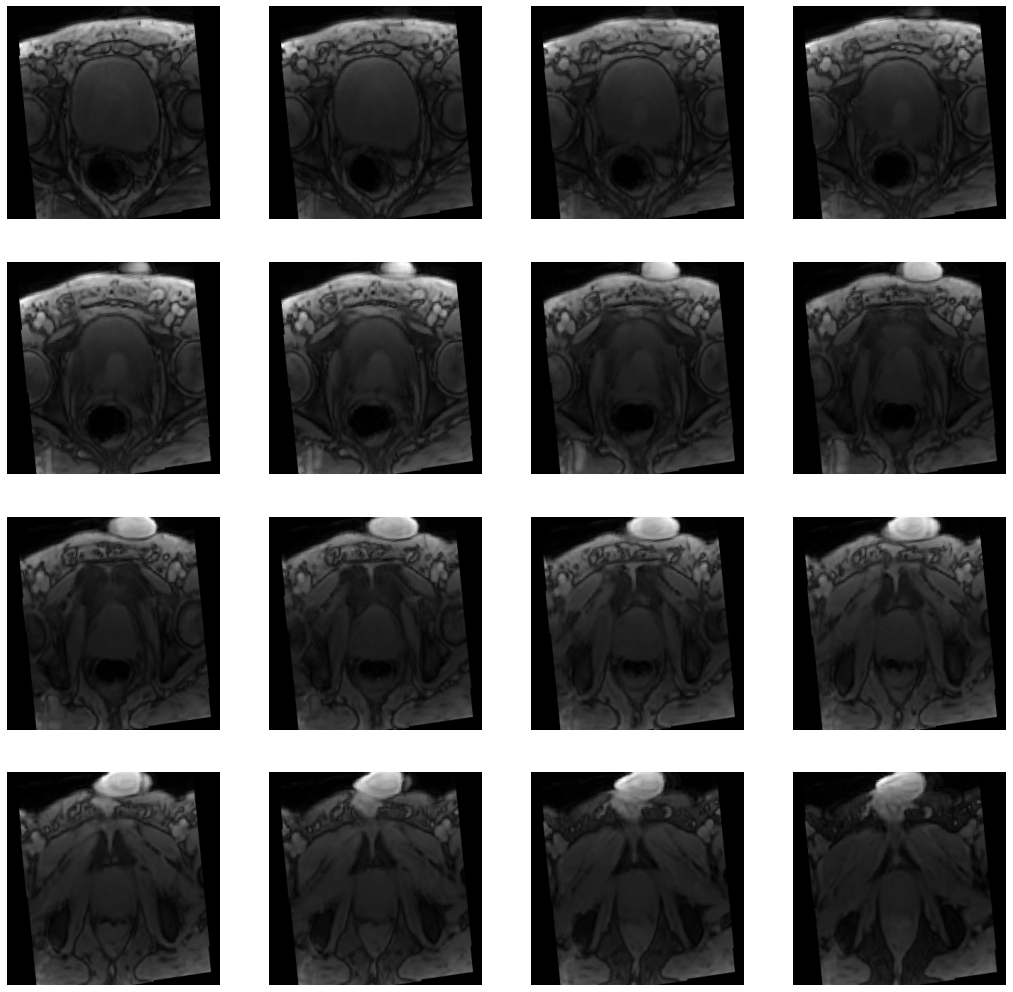

In [ ]:
num_plots=int(np.sqrt(X.shape[2]))
if num_plots**2<X.shape[2]:
  fig, axs=plt.subplots(num_plots,num_plots+1,figsize=(18, 18))
else:
  fig, axs = plt.subplots(num_plots,num_plots,figsize=(18, 18))

for block in X:
  im=np.squeeze(block)
  for slice1,ax in zip(im, axs.ravel()):
    ax.imshow(slice1,cmap='gray')
    ax.axis("off")
plt.axis("off");

In [ ]:
y.shape

(16,)

In [ ]:
y

array([1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0.],
      dtype=float32)

In [ ]:
X.shape[1:]

(1, 16, 300, 300)

In [ ]:
# define model architecture like how you normally do

input_dims=X.shape[1:]
inputs = Input(shape=input_dims)
x1=Conv3D(filters=16, padding='same',kernel_initializer='he_uniform',
          kernel_size=(1,7,7), activation='relu')(inputs)
x1_1=LeakyReLU(0.1)(x1)

x2=Conv3D(filters=32,padding='same',kernel_initializer='he_uniform',
          kernel_size=(1,3,3), activation='relu')(inputs)
x2_1=LeakyReLU(0.1)(x2)

# x3=Conv3D(filters=32, padding='same', kernel_initializer='he_uniform',
#           kernel_size=(1,3,3), activation='relu')(inputs)
# x3_1=LeakyReLU(0.3)(x3)

# x4=Concatenate()([x1_1,x2_1,x3_1])
x4=Concatenate()([x1_1,x2_1])

x5=MaxPooling3D(pool_size=(2,2,2), padding='same')(x4)
x6=Conv3D(filters=64, padding='same', kernel_size=(2,3,3), activation='relu')(x5)
x6_1=LeakyReLU(0.1)(x6)

x7=Conv3D(filters=64, padding='same', kernel_size=(2,3,3), activation='relu')(x6_1)
x7_1=LeakyReLU(0.1)(x7)

x8=Conv3D(filters=32, padding='same', kernel_size=(2,3,3), activation='relu')(x7_1)
x8_1=LeakyReLU(0.1)(x8)

x9=Flatten()(x8_1)
x10=Dropout(0.3)(x9)
x=Dense(64, activation='relu',
        kernel_regularizer=l2(0.01)
        )(x10)
x=Dropout(0.3)(x)
x=Dense(32, activation='relu',
        kernel_regularizer=l2(0.01)
        )(x)     
x=Dropout(0.3)(x)
x=Dense(10, activation='relu',
        kernel_regularizer=l2(0.01)
        )(x)  


out1 = Dense(1, activation="sigmoid",name="out1")(x)

model = Model(inputs=inputs, outputs=out1)




In [ ]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 1, 16, 300,  0           []                               
                                 300)]                                                            
                                                                                                  
 conv3d_15 (Conv3D)             (None, 1, 16, 300,   235216      ['input_4[0][0]']                
                                16)                                                               
                                                                                                  
 conv3d_16 (Conv3D)             (None, 1, 16, 300,   86432       ['input_4[0][0]']                
                                32)                                                         

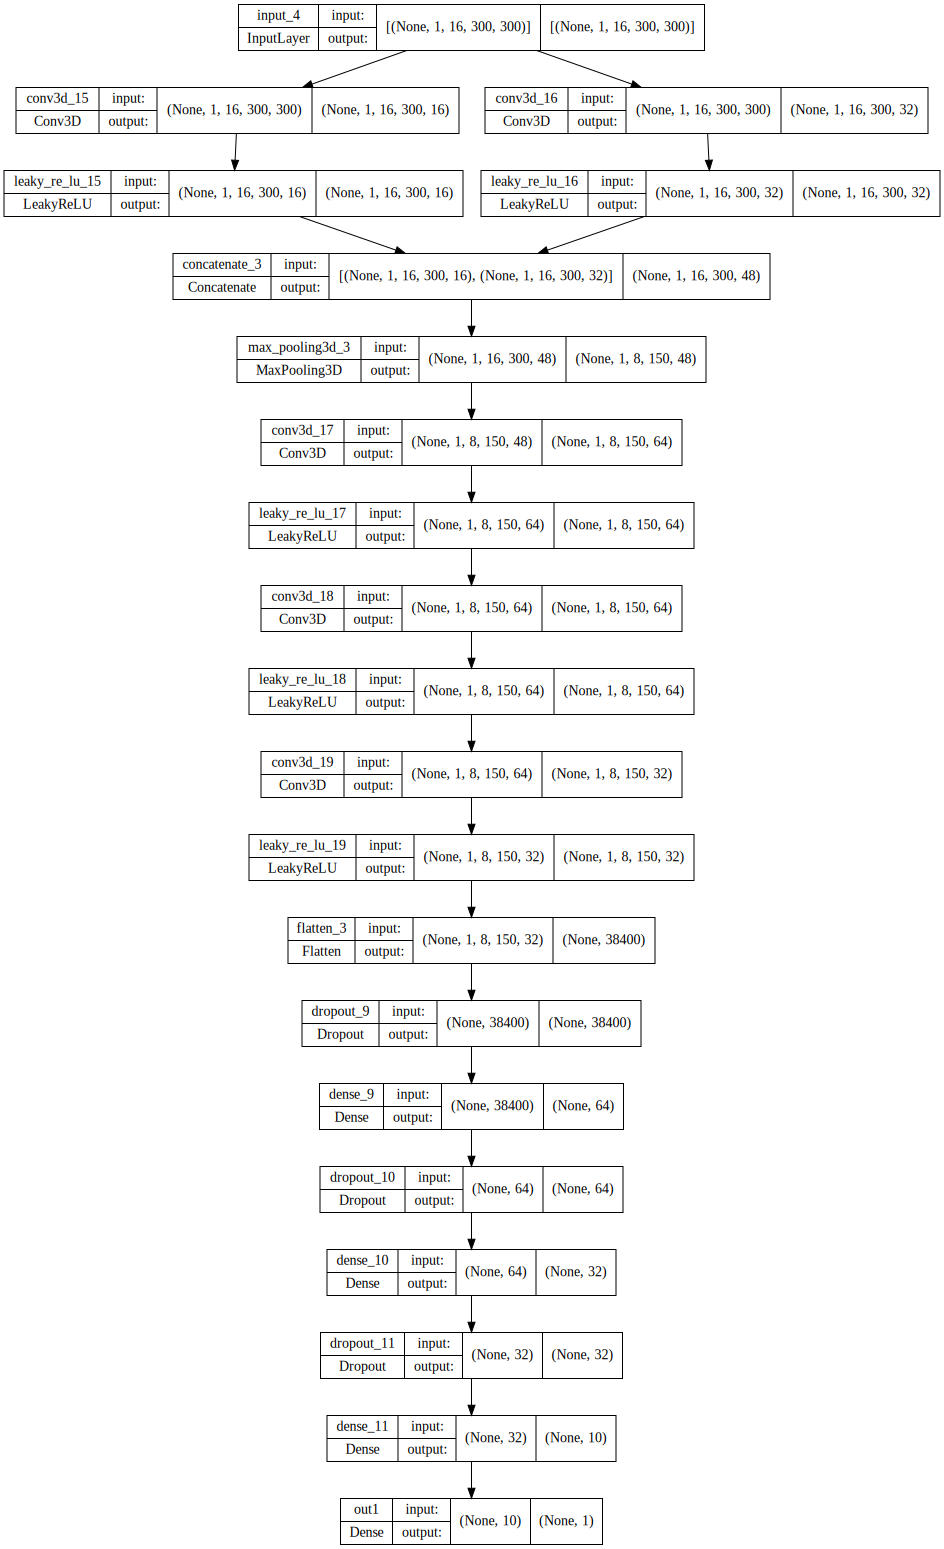

In [ ]:
if COLAB:
    display(SVG(model_to_dot(model, show_shapes=True,dpi=72).create(prog='dot', format='svg')))
else:
    display(SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg')))

In [ ]:
number_train_samples=tr_df_all_dcm.shape[0]
num_train_steps=(number_train_samples // BATCH_SIZE)*EPOCHS
lr_scheduler = tf.keras.optimizers.schedules.PolynomialDecay(initial_learning_rate=0.001,
                               end_learning_rate=1e-8,
                               decay_steps=num_train_steps)

In [ ]:
acum_tr_acc = []
acum_val_acc = []
best_val_acc = -1000
acum_tr_loss  = []
acum_val_loss = []

In [ ]:
model.compile(loss='binary_crossentropy',
             optimizer=Adam(learning_rate=lr_scheduler),
              # optimizer=SGD(lr = 0.01, decay = 1e-6, momentum = 0.9, nesterov = True),
              # optimizer=optimizers.rmsprop_v2.RMSprop(learning_rate=0.001),
              metrics=['accuracy'])

In [ ]:
modelpath="/content/drive/MyDrive/Capstone/Modelos/model_current_best_tfl_tra.h5"

checkpoint = ModelCheckpoint(modelpath, monitor='val_accuracy', verbose=1,
                             save_best_only=True,
                             mode='max') # graba sólo los que mejoran en validación
callbacks_list = [checkpoint]

In [ ]:
number_train_samples = traingen.n
number_val_samples   = valgen.n
number_test_samples  = testgen.n

number_train_samples, number_val_samples, number_test_samples

(183, 74, 91)

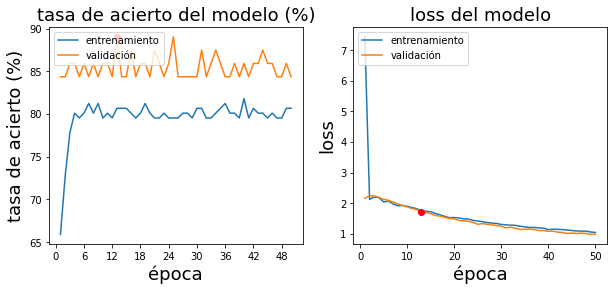

In [ ]:
for e in range(EPOCHS):
    history = model.fit(traingen,  
                        steps_per_epoch=number_train_samples // BATCH_SIZE,
                        epochs=1,
                        callbacks=callbacks_list,
                        verbose=1,
                        shuffle = True,
                        validation_data=valgen,
                        validation_steps=number_val_samples // BATCH_SIZE
                       )
    
    if history.history['val_accuracy'][-1] > best_val_acc:
        print("Validation accuracy improved from",
            best_val_acc, 'to', history.history['val_accuracy'])
        print("saving weights")
        best_val_acc = history.history['val_accuracy'][-1]
    
    acum_tr_acc.append(history.history['accuracy'][0])
    acum_val_acc.append(history.history['val_accuracy'][0])
    acum_tr_loss.append(history.history['loss'][0])
    acum_val_loss.append(history.history['val_loss'][0])
    
    if len(acum_tr_acc) > 1:
        clear_output()
        best_i = np.argmax(acum_val_acc)
        grafica_entrenamiento(acum_tr_acc, acum_val_acc, acum_tr_loss, acum_val_loss, best_i)

In [ ]:
history.history

{'accuracy': [0.8068181872367859],
 'loss': [1.0444592237472534],
 'val_accuracy': [0.84375],
 'val_loss': [0.9902080297470093]}

In [ ]:
# Using the testing generator to evaluate the model after training

test_loss, test_accuracy = model.evaluate(testgen, steps=number_test_samples// BATCH_SIZE)

5/5 [==============================] - 249s 62s/step - loss: 1.1189 - accuracy: 0.7500


## Modelo con CNN's utilizando resonancia magnética __t2_tse_cor0__

In [ ]:
mri='t2_tse_cor0'                    

In [ ]:
tr_df_all_adc=tr_df_all_dcm[tr_df_all_dcm['name']==mri]
val_df_all_adc=val_df_all_dcm[val_df_all_dcm['name']==mri]
test_df_all_adc=test_df_all_dcm[test_df_all_dcm['name']==mri]

In [ ]:
traingen = DicomDataGen(tr_df_all_adc,
                        X_col={'path':'path_dcm'},
                        y_col={'name': 'clinSig'},
                        image_data_generator=train_augmenter,
                        batch_size=BATCH_SIZE, input_size=TARGET_SIZE)

valgen = DicomDataGen(val_df_all_adc,
                      X_col={'path':'path_dcm'},
                      y_col={'name': 'clinSig'},
                      image_data_generator=valid_augmenter,
                      batch_size=BATCH_SIZE, input_size=TARGET_SIZE)

testgen=DicomDataGen(test_df_all_adc,
                     X_col={'path':'path_dcm'},
                     y_col={'name': 'clinSig'},
                     batch_size=BATCH_SIZE, input_size=TARGET_SIZE)


In [ ]:
X, y= traingen[0]
X.shape

(16, 1, 15, 300, 300)

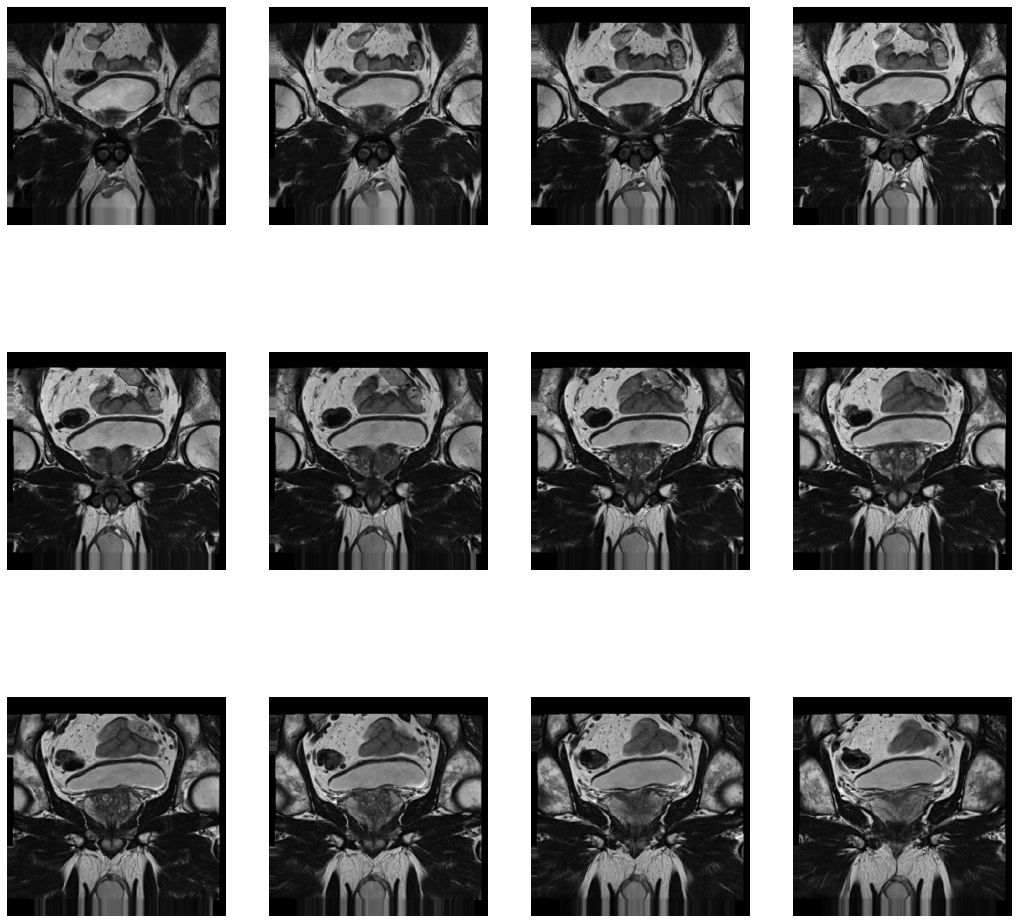

In [ ]:
num_plots=int(np.sqrt(X.shape[2]))
if num_plots**2<X.shape[2]:
  fig, axs=plt.subplots(num_plots,num_plots+1,figsize=(18, 18))
else:
  fig, axs = plt.subplots(num_plots,num_plots,figsize=(18, 18))

for block in X:
  im=np.squeeze(block)
  for slice1,ax in zip(im, axs.ravel()):
    ax.imshow(slice1,cmap='gray')
    ax.axis("off")
plt.axis("off");

In [ ]:
y.shape

(16,)

In [ ]:
y

array([0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

In [ ]:
X.shape[1:]

(1, 15, 300, 300)

In [ ]:
# define model architecture like how you normally do

input_dims=X.shape[1:]
inputs = Input(shape=input_dims)
x1=Conv3D(filters=16, padding='same',kernel_initializer='he_uniform',
          kernel_size=(1,7,7), activation='relu')(inputs)
x1_1=LeakyReLU(0.1)(x1)

x2=Conv3D(filters=32,padding='same',kernel_initializer='he_uniform',
          kernel_size=(1,3,3), activation='relu')(inputs)
x2_1=LeakyReLU(0.1)(x2)

# x3=Conv3D(filters=32, padding='same', kernel_initializer='he_uniform',
#           kernel_size=(1,3,3), activation='relu')(inputs)
# x3_1=LeakyReLU(0.3)(x3)

# x4=Concatenate()([x1_1,x2_1,x3_1])
x4=Concatenate()([x1_1,x2_1])

x5=MaxPooling3D(pool_size=(2,2,2), padding='same')(x4)
x6=Conv3D(filters=64, padding='same', kernel_size=(2,3,3), activation='relu')(x5)
x6_1=LeakyReLU(0.1)(x6)

x7=Conv3D(filters=64, padding='same', kernel_size=(2,3,3), activation='relu')(x6_1)
x7_1=LeakyReLU(0.1)(x7)

x8=Conv3D(filters=32, padding='same', kernel_size=(2,3,3), activation='relu')(x7_1)
x8_1=LeakyReLU(0.1)(x8)

x9=Flatten()(x8_1)
x10=Dropout(0.3)(x9)
x=Dense(64, activation='relu',
        kernel_regularizer=l2(0.01)
        )(x10)
x=Dropout(0.3)(x)
x=Dense(32, activation='relu',
        kernel_regularizer=l2(0.01)
        )(x)     
x=Dropout(0.3)(x)
x=Dense(10, activation='relu',
        kernel_regularizer=l2(0.01)
        )(x)  


out1 = Dense(1, activation="sigmoid",name="out1")(x)

model = Model(inputs=inputs, outputs=out1)




In [ ]:
model.summary()

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 1, 15, 300,  0           []                               
                                 300)]                                                            
                                                                                                  
 conv3d_64 (Conv3D)             (None, 1, 15, 300,   235216      ['input_13[0][0]']               
                                16)                                                               
                                                                                                  
 conv3d_65 (Conv3D)             (None, 1, 15, 300,   86432       ['input_13[0][0]']               
                                32)                                                        

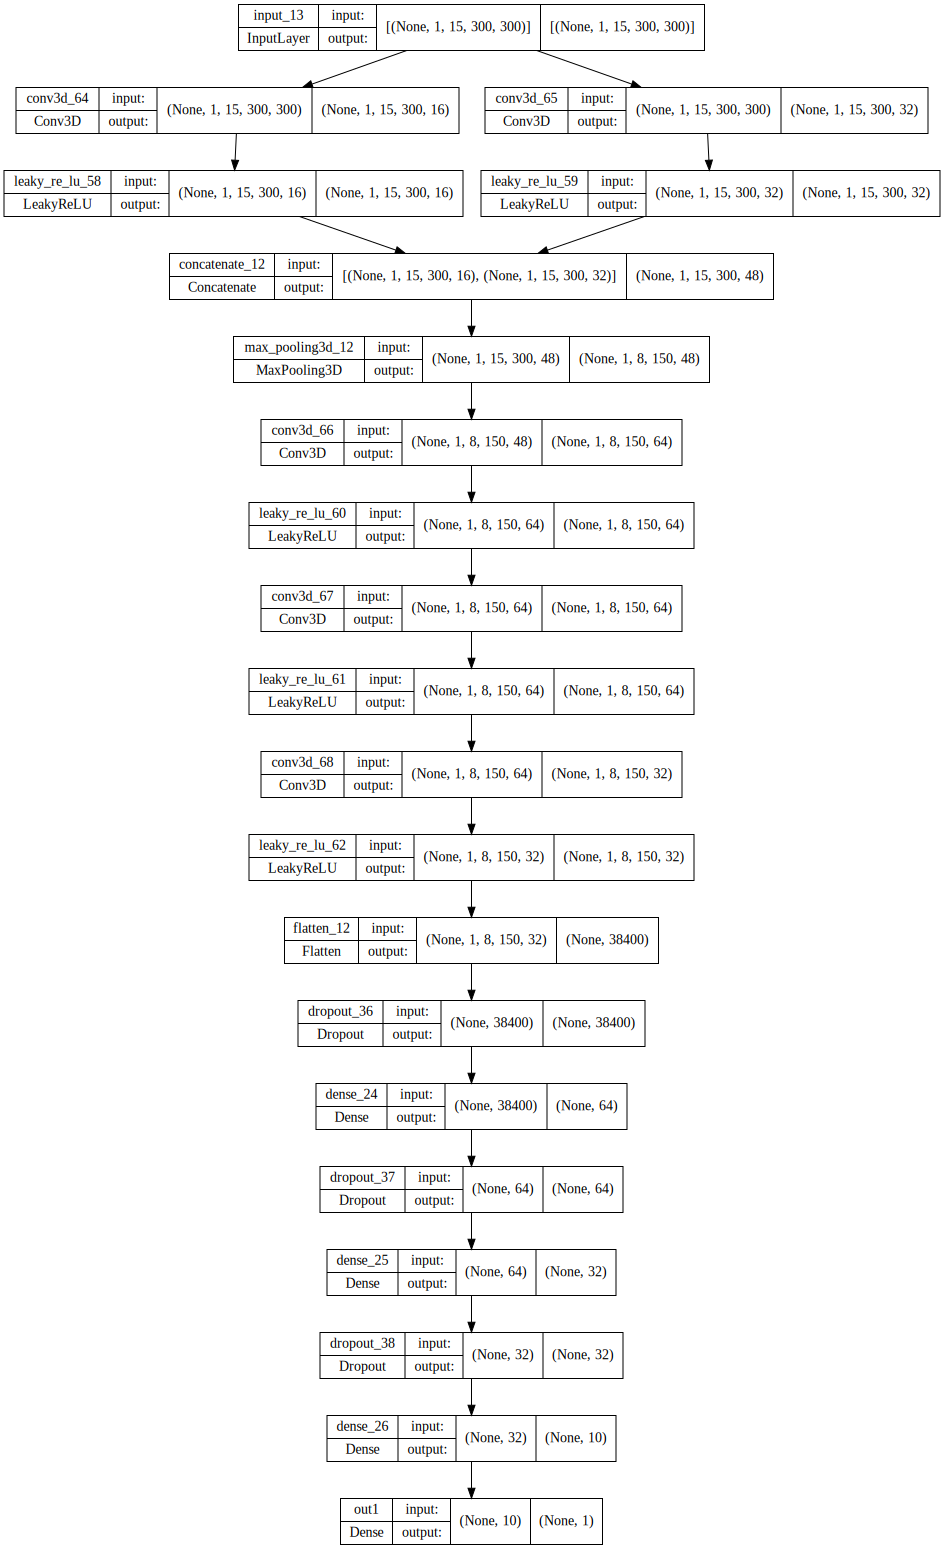

In [ ]:
if COLAB:
    display(SVG(model_to_dot(model, show_shapes=True,dpi=72).create(prog='dot', format='svg')))
else:
    display(SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg')))

In [ ]:
number_train_samples=tr_df_all_dcm.shape[0]
num_train_steps=(number_train_samples // BATCH_SIZE)*EPOCHS
lr_scheduler = tf.keras.optimizers.schedules.PolynomialDecay(initial_learning_rate=0.001,
                               end_learning_rate=1e-8,
                               decay_steps=num_train_steps)

In [ ]:
acum_tr_acc = []
acum_val_acc = []
best_val_acc = -1000
acum_tr_loss  = []
acum_val_loss = []

In [ ]:
model.compile(loss='binary_crossentropy',
             optimizer=Adam(learning_rate=lr_scheduler),
              # optimizer=SGD(lr = 0.01, decay = 1e-6, momentum = 0.9, nesterov = True),
              # optimizer=optimizers.rmsprop_v2.RMSprop(learning_rate=0.001),
              metrics=['accuracy'])

In [ ]:
modelpath="/content/drive/MyDrive/Capstone/Modelos/model_current_best_t2_tse_cor0.h5"

checkpoint = ModelCheckpoint(modelpath, monitor='val_accuracy', verbose=1,
                             save_best_only=True,
                             mode='max') # graba sólo los que mejoran en validación
callbacks_list = [checkpoint]

In [ ]:
number_train_samples = traingen.n
number_val_samples   = valgen.n
number_test_samples  = testgen.n

number_train_samples, number_val_samples, number_test_samples

(84, 23, 62)

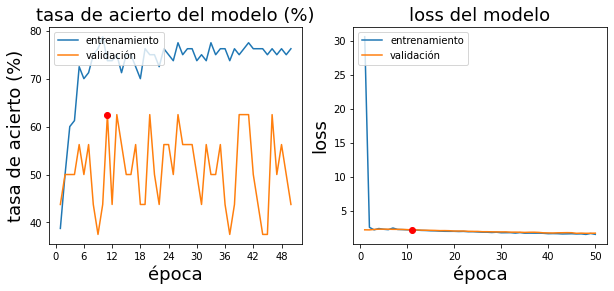

In [ ]:
for e in range(EPOCHS):
    history = model.fit(traingen,  
                        steps_per_epoch=number_train_samples // BATCH_SIZE,
                        epochs=1,
                        callbacks=callbacks_list,
                        verbose=1,
                        shuffle = True,
                        validation_data=valgen,
                        validation_steps=number_val_samples // BATCH_SIZE
                       )
    
    if history.history['val_accuracy'][-1] > best_val_acc:
        print("Validation accuracy improved from",
            best_val_acc, 'to', history.history['val_accuracy'])
        print("saving weights")
        best_val_acc = history.history['val_accuracy'][-1]
    
    acum_tr_acc.append(history.history['accuracy'][0])
    acum_val_acc.append(history.history['val_accuracy'][0])
    acum_tr_loss.append(history.history['loss'][0])
    acum_val_loss.append(history.history['val_loss'][0])
    
    if len(acum_tr_acc) > 1:
        clear_output()
        best_i = np.argmax(acum_val_acc)
        grafica_entrenamiento(acum_tr_acc, acum_val_acc, acum_tr_loss, acum_val_loss, best_i)

In [ ]:
history.history

{'accuracy': [0.762499988079071],
 'loss': [1.5255335569381714],
 'val_accuracy': [0.4375],
 'val_loss': [1.7019259929656982]}

In [ ]:
# Using the testing generator to evaluate the model after training

test_loss, test_accuracy = model.evaluate(testgen, steps=number_test_samples// BATCH_SIZE)

3/3 [==============================] - 113s 55s/step - loss: 1.5703 - accuracy: 0.8333


## Modelo con CNN's utilizando resonancia magnética __t2_tse_sag0__

In [ ]:
mri='t2_tse_sag0'                

In [ ]:
tr_df_all_adc=tr_df_all_dcm[tr_df_all_dcm['name']==mri]
val_df_all_adc=val_df_all_dcm[val_df_all_dcm['name']==mri]
test_df_all_adc=test_df_all_dcm[test_df_all_dcm['name']==mri]

In [ ]:
traingen = DicomDataGen(tr_df_all_adc,
                        X_col={'path':'path_dcm'},
                        y_col={'name': 'clinSig'},
                        image_data_generator=train_augmenter,
                        batch_size=BATCH_SIZE, input_size=TARGET_SIZE)

valgen = DicomDataGen(val_df_all_adc,
                      X_col={'path':'path_dcm'},
                      y_col={'name': 'clinSig'},
                      image_data_generator=valid_augmenter,
                      batch_size=BATCH_SIZE, input_size=TARGET_SIZE)

testgen=DicomDataGen(test_df_all_adc,
                     X_col={'path':'path_dcm'},
                     y_col={'name': 'clinSig'},
                     batch_size=BATCH_SIZE, input_size=TARGET_SIZE)


In [ ]:
X, y= traingen[0]
X.shape

(16, 1, 19, 300, 300)

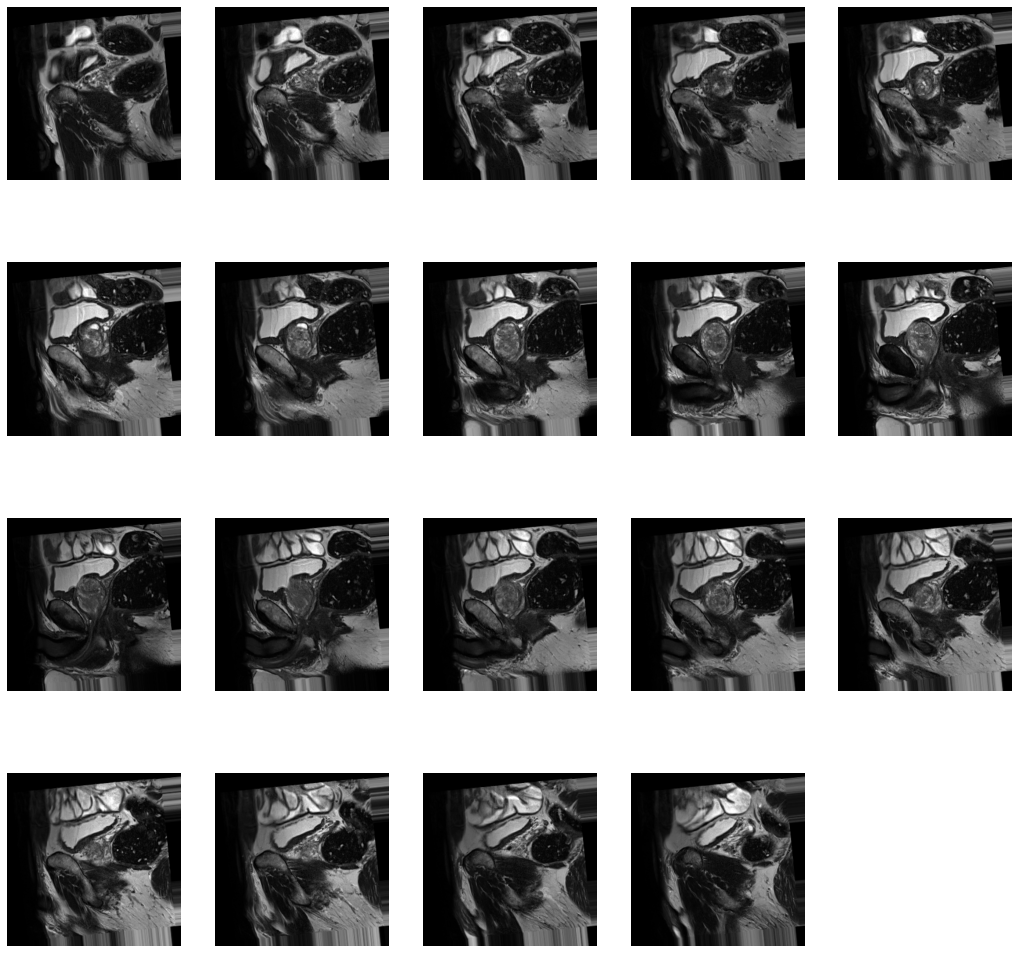

In [ ]:
num_plots=int(np.sqrt(X.shape[2]))
if num_plots**2<X.shape[2]:
  fig, axs=plt.subplots(num_plots,num_plots+1,figsize=(18, 18))
else:
  fig, axs = plt.subplots(num_plots,num_plots,figsize=(18, 18))

for block in X:
  im=np.squeeze(block)
  for slice1,ax in zip(im, axs.ravel()):
    ax.imshow(slice1,cmap='gray')
    ax.axis("off")
plt.axis("off");

In [ ]:
y.shape

(16,)

In [ ]:
y

array([0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0.],
      dtype=float32)

In [ ]:
X.shape[1:]

(1, 19, 300, 300)

In [ ]:
# define model architecture like how you normally do

input_dims=X.shape[1:]
inputs = Input(shape=input_dims)
x1=Conv3D(filters=16, padding='same',kernel_initializer='he_uniform',
          kernel_size=(1,7,7), activation='relu')(inputs)
x1_1=LeakyReLU(0.1)(x1)

x2=Conv3D(filters=32,padding='same',kernel_initializer='he_uniform',
          kernel_size=(1,3,3), activation='relu')(inputs)
x2_1=LeakyReLU(0.1)(x2)

# x3=Conv3D(filters=32, padding='same', kernel_initializer='he_uniform',
#           kernel_size=(1,3,3), activation='relu')(inputs)
# x3_1=LeakyReLU(0.3)(x3)

# x4=Concatenate()([x1_1,x2_1,x3_1])
x4=Concatenate()([x1_1,x2_1])

x5=MaxPooling3D(pool_size=(2,2,2), padding='same')(x4)
x6=Conv3D(filters=64, padding='same', kernel_size=(2,3,3), activation='relu')(x5)
x6_1=LeakyReLU(0.1)(x6)

x7=Conv3D(filters=64, padding='same', kernel_size=(2,3,3), activation='relu')(x6_1)
x7_1=LeakyReLU(0.1)(x7)

x8=Conv3D(filters=32, padding='same', kernel_size=(2,3,3), activation='relu')(x7_1)
x8_1=LeakyReLU(0.1)(x8)

x9=Flatten()(x8_1)
x10=Dropout(0.3)(x9)
x=Dense(64, activation='relu',
        kernel_regularizer=l2(0.01)
        )(x10)
x=Dropout(0.3)(x)
x=Dense(32, activation='relu',
        kernel_regularizer=l2(0.01)
        )(x)     
x=Dropout(0.3)(x)
x=Dense(10, activation='relu',
        kernel_regularizer=l2(0.01)
        )(x)  


out1 = Dense(1, activation="sigmoid",name="out1")(x)

model = Model(inputs=inputs, outputs=out1)




In [ ]:
model.summary()

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 1, 19, 300,  0           []                               
                                 300)]                                                            
                                                                                                  
 conv3d_50 (Conv3D)             (None, 1, 19, 300,   235216      ['input_11[0][0]']               
                                16)                                                               
                                                                                                  
 conv3d_51 (Conv3D)             (None, 1, 19, 300,   86432       ['input_11[0][0]']               
                                32)                                                        

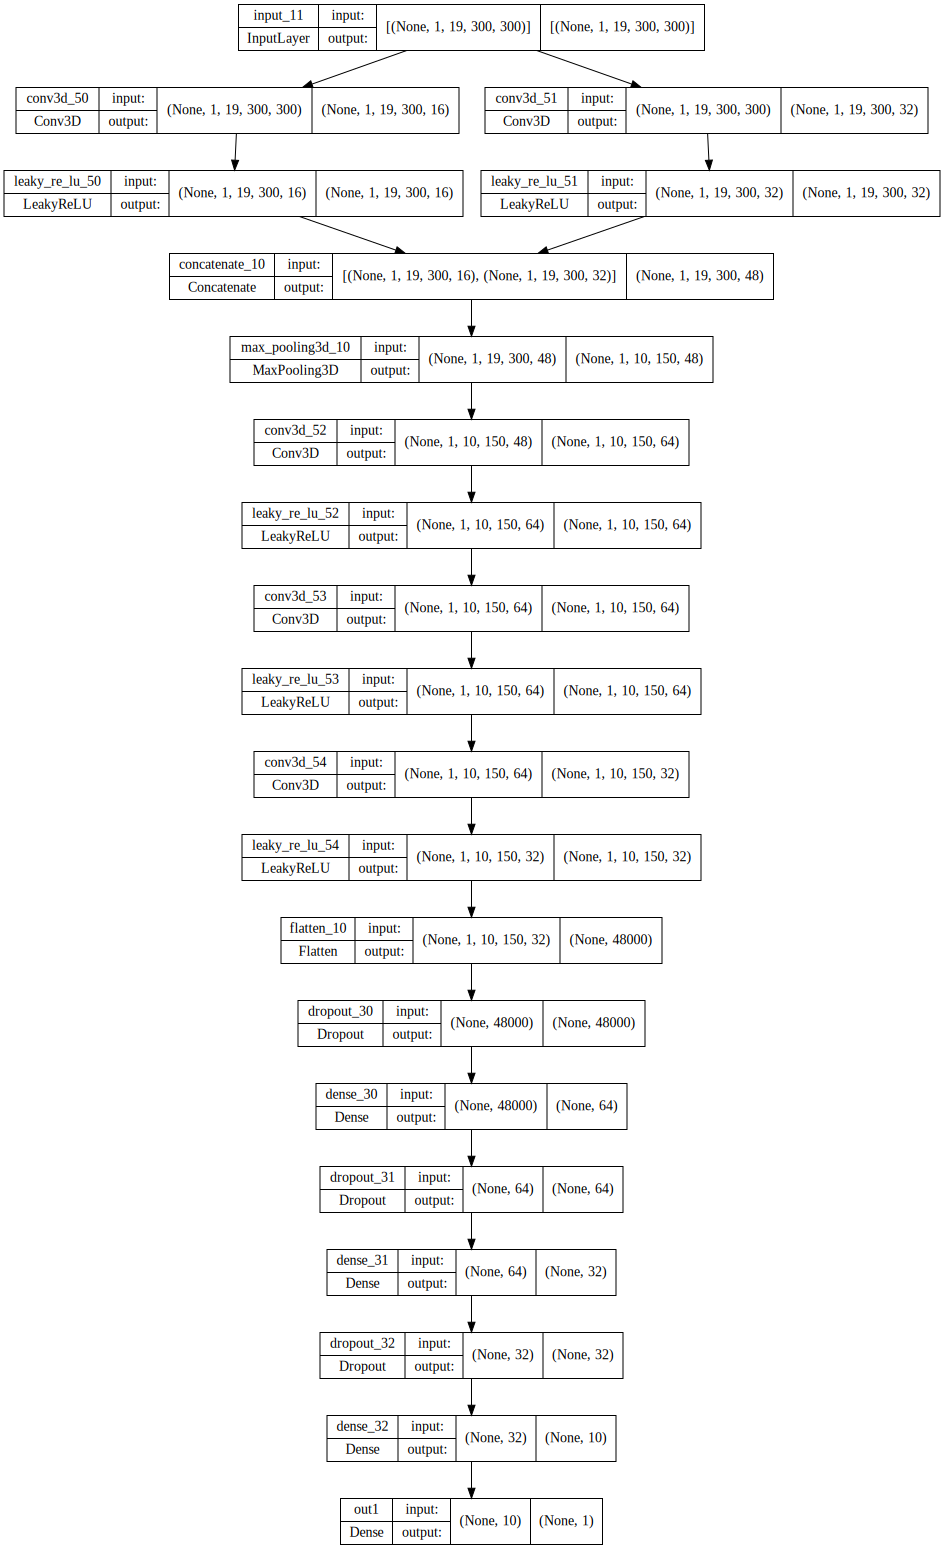

In [ ]:
if COLAB:
    display(SVG(model_to_dot(model, show_shapes=True,dpi=72).create(prog='dot', format='svg')))
else:
    display(SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg')))

In [ ]:
number_train_samples=tr_df_all_dcm.shape[0]
num_train_steps=(number_train_samples // BATCH_SIZE)*EPOCHS
lr_scheduler = tf.keras.optimizers.schedules.PolynomialDecay(initial_learning_rate=0.001,
                               end_learning_rate=1e-8,
                               decay_steps=num_train_steps)

In [ ]:
acum_tr_acc = []
acum_val_acc = []
best_val_acc = -1000
acum_tr_loss  = []
acum_val_loss = []

In [ ]:
model.compile(loss='binary_crossentropy',
             optimizer=Adam(learning_rate=lr_scheduler),
              # optimizer=SGD(lr = 0.01, decay = 1e-6, momentum = 0.9, nesterov = True),
              # optimizer=optimizers.rmsprop_v2.RMSprop(learning_rate=0.001),
              metrics=['accuracy'])

In [ ]:
modelpath="/content/drive/MyDrive/Capstone/Modelos/model_current_best_t2_tse_sag0.h5"

checkpoint = ModelCheckpoint(modelpath, monitor='val_accuracy', verbose=1,
                             save_best_only=True,
                             mode='max') # graba sólo los que mejoran en validación
callbacks_list = [checkpoint]

In [ ]:
number_train_samples = traingen.n
number_val_samples   = valgen.n
number_test_samples  = testgen.n

number_train_samples, number_val_samples, number_test_samples

(195, 67, 95)

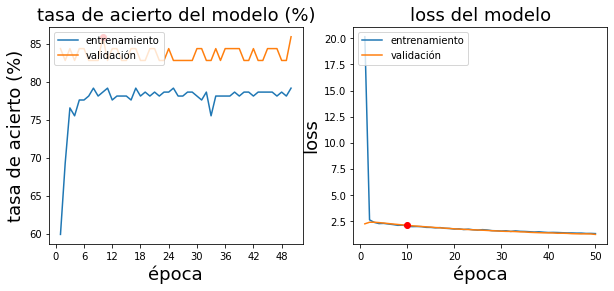

In [ ]:
for e in range(EPOCHS):
    history = model.fit(traingen,  
                        steps_per_epoch=number_train_samples // BATCH_SIZE,
                        epochs=1,
                        callbacks=callbacks_list,
                        verbose=1,
                        shuffle = True,
                        validation_data=valgen,
                        validation_steps=number_val_samples // BATCH_SIZE
                       )
    
    if history.history['val_accuracy'][-1] > best_val_acc:
        print("Validation accuracy improved from",
            best_val_acc, 'to', history.history['val_accuracy'])
        print("saving weights")
        best_val_acc = history.history['val_accuracy'][-1]
    
    acum_tr_acc.append(history.history['accuracy'][0])
    acum_val_acc.append(history.history['val_accuracy'][0])
    acum_tr_loss.append(history.history['loss'][0])
    acum_val_loss.append(history.history['val_loss'][0])
    
    if len(acum_tr_acc) > 1:
        clear_output()
        best_i = np.argmax(acum_val_acc)
        grafica_entrenamiento(acum_tr_acc, acum_val_acc, acum_tr_loss, acum_val_loss, best_i)

In [ ]:
history.history

{'accuracy': [0.7916666865348816],
 'loss': [1.3388234376907349],
 'val_accuracy': [0.859375],
 'val_loss': [1.260097622871399]}

In [ ]:
# Using the testing generator to evaluate the model after training

test_loss, test_accuracy = model.evaluate(testgen, steps=number_test_samples// BATCH_SIZE)

5/5 [==============================] - 256s 64s/step - loss: 1.4517 - accuracy: 0.6875
